# IMPORT NECESSARY PACKAGES

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
# For data loading, manipulation and analysis
import pandas as pd

#For plotting
from matplotlib import pyplot as plt
%matplotlib inline
# For plotting
import seaborn as sns
sns.set_color_codes("dark")
sns.set(font_scale=1)

# For numeric computations
import numpy as np

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import random
from sklearn.utils import resample
#To install xgboost library use - !pip install xgboost 
from xgboost import XGBClassifier
from sklearn.decomposition import PCA 
from scipy.stats import randint as sp_randint
from scipy.stats import uniform
from sklearn.pipeline import Pipeline, make_pipeline

import multiprocessing
# Get CPU count
c_count = multiprocessing.cpu_count()
print("Number of CPUs: ", c_count)

Number of CPUs:  8


In [4]:
print("pandas version: ", pd.__version__) #1.3.0
print("seaborn version: ",sns.__version__) #0.11.1
print("numpy version: ",np.__version__) #1.21.0

pandas version:  1.3.0
seaborn version:  0.11.1
numpy version:  1.21.0


# DATA STRUCTURE

In [5]:
df_original = pd.read_csv("Insurance Premium Default-Dataset.csv")
df_original.head()

,id,perc_premium_paid_by_cash_credit,age_in_days,Income,Count_3-6_months_late,Count_6-12_months_late,Count_more_than_12_months_late,Marital Status,Veh_Owned,No_of_dep,Accomodation,risk_score,no_of_premiums_paid,sourcing_channel,residence_area_type,premium,default
0,1,0.317,11330,90050,0,0,0,0,3,3,1,98.810,8,A,Rural,5400,1
1,2,0.000,30309,156080,0,0,0,1,3,1,1,99.066,3,A,Urban,11700,1
2,3,0.015,16069,145020,1,0,0,0,1,1,1,99.170,14,C,Urban,18000,1
3,4,0.000,23733,187560,0,0,0,1,1,1,0,99.370,13,A,Urban,13800,1
4,5,0.888,19360,103050,7,3,4,0,2,1,0,98.800,15,A,Urban,7500,0


In [6]:
# Rename columns as follows
df_original = df_original.rename(columns={'perc_premium_paid_by_cash_credit':'perc_premium_by_cash',
                                        'Count_3-6_months_late':'count3_6',
                                        'Count_6-12_months_late':'count6_12',
                                        'Count_more_than_12_months_late':'count12_more',
                                        'Marital Status':'marital_status',
                                        'Veh_Owned':'vehicles',
                                        'residence_area_type': 'residence',
                                        'Accomodation': 'accomodation',
                                        'No_of_dep':'dependants',
                                        'Income':'income'
                                         })


# The following are some columns that are best regarded as categorical though interger-encoded. 
# Converting them as so.
col1 = ['marital_status', 'accomodation',
       'sourcing_channel', 'residence', 'default']
df_original[col1] = df_original[col1].astype('category')

# Make a copy of the DataFrame
df = df_original.copy()

In [7]:
# data information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79853 entries, 0 to 79852
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   id                    79853 non-null  int64   
 1   perc_premium_by_cash  79853 non-null  float64 
 2   age_in_days           79853 non-null  int64   
 3   income                79853 non-null  int64   
 4   count3_6              79853 non-null  int64   
 5   count6_12             79853 non-null  int64   
 6   count12_more          79853 non-null  int64   
 7   marital_status        79853 non-null  category
 8   vehicles              79853 non-null  int64   
 9   dependants            79853 non-null  int64   
 10  accomodation          79853 non-null  category
 11  risk_score            79853 non-null  float64 
 12  no_of_premiums_paid   79853 non-null  int64   
 13  sourcing_channel      79853 non-null  category
 14  residence             79853 non-null  category
 15  pr

In [8]:
# From the data information above there seems to be no missing information
# but we are going to check some columns (categorical) to ensure that the classes in such columns
# are as expected.

cat_cols = ['marital_status', 'vehicles',
       'dependants', 'accomodation','sourcing_channel', 'residence', 'default']

for col in cat_cols:
    print(col,"--- classes",df[col].unique())
    
# From the output, the classes are consistent with the data description

marital_status --- classes [0, 1]
Categories (2, int64): [0, 1]
vehicles --- classes [3 1 2]
dependants --- classes [3 1 4 2]
accomodation --- classes [1, 0]
Categories (2, int64): [0, 1]
sourcing_channel --- classes ['A', 'C', 'B', 'D', 'E']
Categories (5, object): ['A', 'B', 'C', 'D', 'E']
residence --- classes ['Rural', 'Urban']
Categories (2, object): ['Rural', 'Urban']
default --- classes [1, 0]
Categories (2, int64): [0, 1]


**Observations**

- There are 79853 rows and 17 columns in the DataFrame.
- No missing values in the data for all the columns.
- The DataFrame contain both numeric and string data.
- The data takes roughly 11MB on memory.

# EXPLORATORY DATA ANALYSIS

In [9]:
df.describe(include="all")

,id,perc_premium_by_cash,age_in_days,income,count3_6,count6_12,count12_more,marital_status,vehicles,dependants,accomodation,risk_score,no_of_premiums_paid,sourcing_channel,residence,premium,default
count,79853.00000,79853.000000,79853.000000,7.985300e+04,79853.000000,79853.000000,79853.000000,79853.0,79853.000000,79853.000000,79853.0,79853.000000,79853.000000,79853,79853,79853.000000,79853.0
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,2.0,NaN,NaN,5,2,NaN,2.0
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,1.0,NaN,NaN,A,Urban,NaN,1.0
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40032.0,NaN,NaN,40030.0,NaN,NaN,43134,48183,NaN,74855.0
mean,39927.00000,0.314288,18846.696906,2.088472e+05,0.248369,0.078093,0.059935,NaN,1.998009,2.503012,NaN,99.067243,10.863887,NaN,NaN,10924.507533,NaN
std,23051.71986,0.334915,5208.719136,4.965826e+05,0.691102,0.436251,0.311840,NaN,0.817248,1.115901,NaN,0.725892,5.170687,NaN,NaN,9401.676542,NaN
min,1.00000,0.000000,7670.000000,2.403000e+04,0.000000,0.000000,0.000000,NaN,1.000000,1.000000,NaN,91.900000,2.000000,NaN,NaN,1200.000000,NaN
25%,19964.00000,0.034000,14974.000000,1.080100e+05,0.000000,0.000000,0.000000,NaN,1.000000,2.000000,NaN,98.830000,7.000000,NaN,NaN,5400.000000,NaN
50%,39927.00000,0.167000,18625.000000,1.665600e+05,0.000000,0.000000,0.000000,NaN,2.000000,3.000000,NaN,99.180000,10.000000,NaN,NaN,7500.000000,NaN
75%,59890.00000,0.538000,22636.000000,2.520900e+05,0.000000,0.000000,0.000000,NaN,3.000000,3.000000,NaN,99.520000,14.000000,NaN,NaN,13800.000000,NaN


0    50.132118
1    49.867882
Name: marital_status, dtype: float64


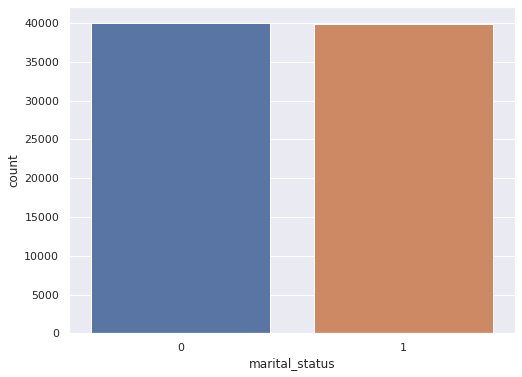

0    49.870387
1    50.129613
Name: accomodation, dtype: float64


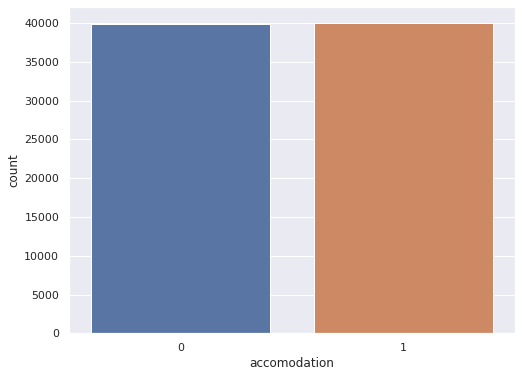

A    54.016756
B    20.677996
C    15.076453
D     9.466144
E     0.762651
Name: sourcing_channel, dtype: float64


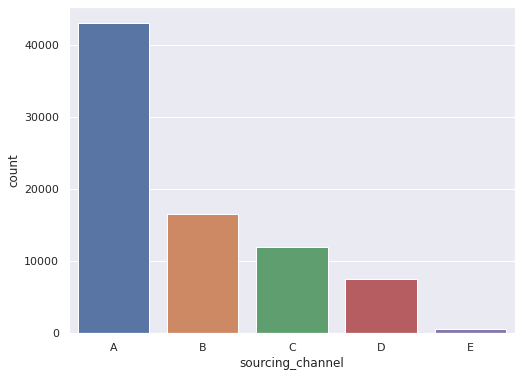

Rural    39.660376
Urban    60.339624
Name: residence, dtype: float64


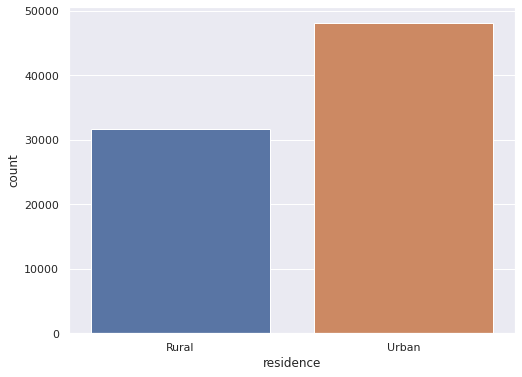

0     6.259001
1    93.740999
Name: default, dtype: float64


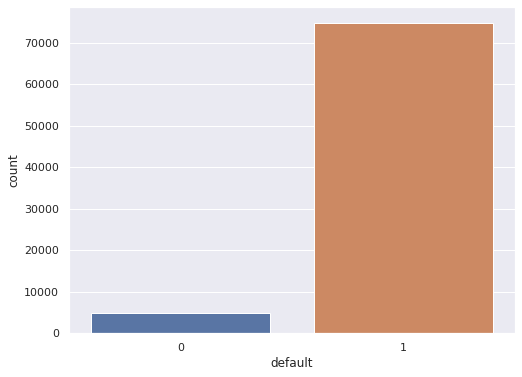

0     83.776439
1     11.052810
7      0.028803
2      3.154546
3      1.194695
8      0.018785
4      0.468361
5      0.210387
6      0.085156
13     0.001252
12     0.001252
10     0.001252
9      0.005009
11     0.001252
Name: count3_6, dtype: float64


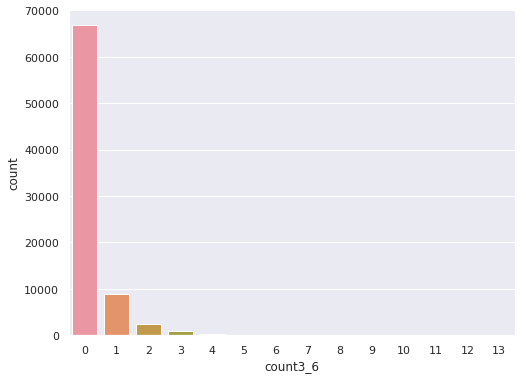

0     95.084718
3      0.396979
1      3.356167
4      0.162799
2      0.867845
11     0.002505
5      0.057606
9      0.005009
6      0.032560
8      0.006262
7      0.013775
10     0.005009
14     0.002505
13     0.002505
15     0.001252
17     0.001252
12     0.001252
Name: count6_12, dtype: float64


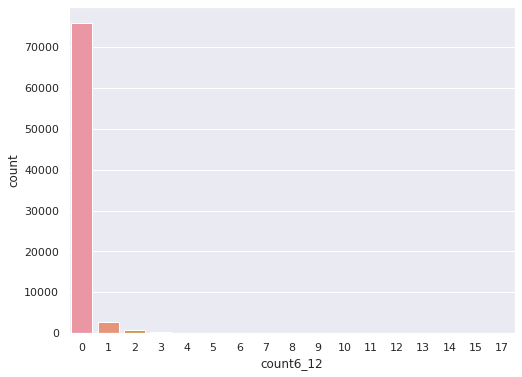

0     95.343944
4      0.060110
1      3.751894
2      0.623646
3      0.189097
5      0.016280
8      0.002505
6      0.007514
7      0.003757
11     0.001252
Name: count12_more, dtype: float64


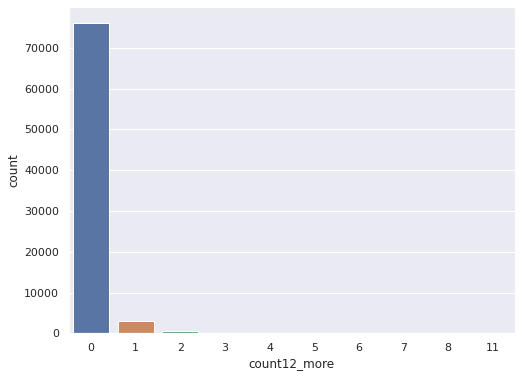

In [10]:
all_categories = ['marital_status', 'accomodation',
                'sourcing_channel', 'residence', 'default',
                'count3_6', 'count6_12',
                'count12_more']

for category in all_categories:
    # Top 5 in each category in terms of count in per cent
    stats = df[category].value_counts(normalize=True, sort=False)*100
    print(stats)
    plt.figure(figsize=(8,6))
    sns.countplot(x=category, data=df) 
    plt.show()

**Observations:**

- perc_premium_by_cash is the percentage of premium paid by cash. The mean is 31.4% and the third Q is at 53.8% meaning that few customers pays the premium by cash. 
- The average age of individuals in the dataset is 18846.7 days with the youngest individual being 7670 and the eldest 37602 days. With the 3rd Q being 22636 days we expect outliers for this attribute. We will transfor this variable later.
- The people, on average, paid a total of 10924 on premium. The maximum paid is 60000 and the minimum premium paid is 1200. The median is 7500 indicating likelihood of having outliers for this attribute. We will investigate that later.
- The mean of income is 208847 and the minimum income is 24030 with the maximum is 90262600 and the median is 166560 a clear indication of skewness. We will investigate this later also.
- On marital_status, 50.1% of the people are unmarried(0) and 49.9% are married.
- risk_score has a min of 91.9% and max of 99.9% with median of mean of 99.07% meaning that most clients are have risk_score near maximum than minimum. Infact 1st Q is at 98.83%.
- count3_6, third Q is 0 implying that most customers are paying the the premium on time. In fact 83.78% of the customers paid the premium on time and the rest delaying at least once. Maximu delay is 13, that is,13 times premium was paid 3-6 months late.
- For count_6-12, 95.1% of the customers paid on time with max of 17 times delay. 
- FOr count12_more, 95.3% paid on time with maximum of 11 times in delay.
- The mean number of vehicles owned is 2 with min at 1 and max at 3. This suggest that the insurance policy in this data might involve vehicle insurance cover.
- 60.3% of the customers reside in urban areas and the 39.7% in the rural.
- Majority of customers were source using channel A (54.02%) followed by channel B(20.7) and C coming third with 15.1%. The least of the customers representing 0.76% were sourced using method E.
- Classifications of customers based on accomodation classes is nearly 50-50. 49.87% renting and 50.13% are house owners.
- On no_of_premiums_paid, the max is 60. Inferring from this value and assuming that the premiums are paid monthly, we can hypothersise that the data was collected over a period of 60/12=5 years.
- 93.7% of the customers are non-defaulters.

In [11]:
numerical_cols = list(df.select_dtypes(np.number).columns)
print(numerical_cols)

['id', 'perc_premium_by_cash', 'age_in_days', 'income', 'count3_6', 'count6_12', 'count12_more', 'vehicles', 'dependants', 'risk_score', 'no_of_premiums_paid', 'premium']


In [12]:
# Function to plot histogram and boxplot for numerical variables as we study the 
# central tendency and dispersion for such values
def histogram_boxplot(feature, figsize=(10,8), bins = None):
    """ 
    Boxplot and histogram combined with shared axis
    feature: 1-d feature array
    figsize: size of fig (default (10,8))
    bins: number of bins (default None / auto)
    """
    
    f2, (ax_box2, ax_hist2) = plt.subplots(nrows = 2, # Number of rows of the subplot grid= 2
                                           sharex = True, # x-axis will be shared among all subplots
                                           gridspec_kw = {"height_ratios": (.25, .75)}, 
                                           figsize = figsize 
                                           ) # creating the 2 subplots
    sns.boxplot(x=feature, ax=ax_box2, showmeans=True, color='red') # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(x=feature, kde=False, ax=ax_hist2, bins=bins) if bins else sns.histplot(x=feature, kde=False, ax=ax_hist2) # For histogram
    ax_hist2.axvline(np.mean(feature), color='green', linestyle='--') # Add mean to the histogram
    ax_hist2.axvline(np.median(feature), color='black', linestyle='-') # Add median to the histogram
    y_min, y_max = ax_hist2.get_ylim()
    x_min, x_max = ax_hist2.get_xlim()
    print(0.8*max(feature), max(feature))
    print(0.8*y_max, y_max)
    x = 0.8*max(feature)
    y = 0.8*y_max
    if y<y_min:
        y = y_min
    ax_hist2.text(x_max, y, 'Skew: {}'.format(round(feature.skew(),2)), dict(size=15))
    ax_hist2.text(x_max, y-0.1*(y_max), 'Kurtosis: {}'.format(round(feature.kurtosis(),2)), dict(size=15))

0.8 1.0
8920.800000000001 11151.0


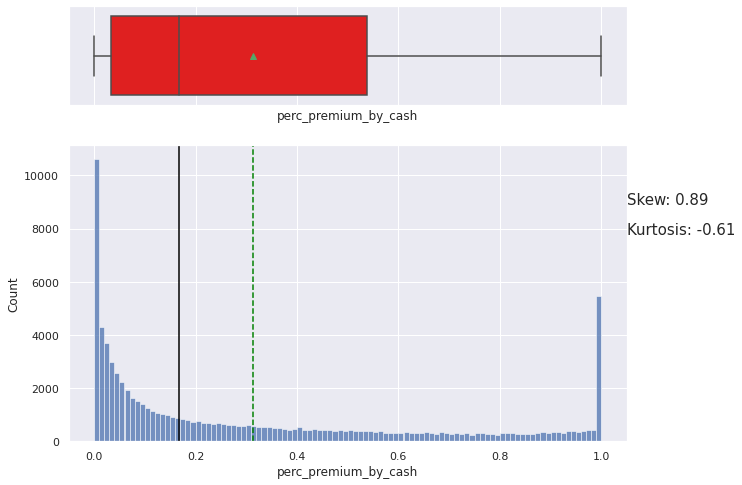

In [13]:
histogram_boxplot(df.perc_premium_by_cash,bins=100)

**Observation(perc_premium_by_cash):**
- Median is around 18% and mean roughly 30%. There is a spike at 0% and at 100% for those people who don't pay cash at all and those who pay by cash all the time, respectively.

72210080.0 90262600
2542.6800000000003 3178.35


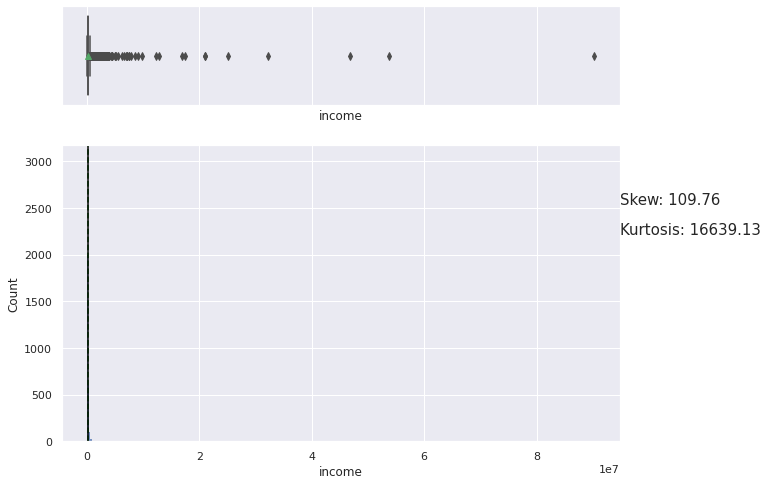

919704.0 1149630
2892.1200000000003 3615.15


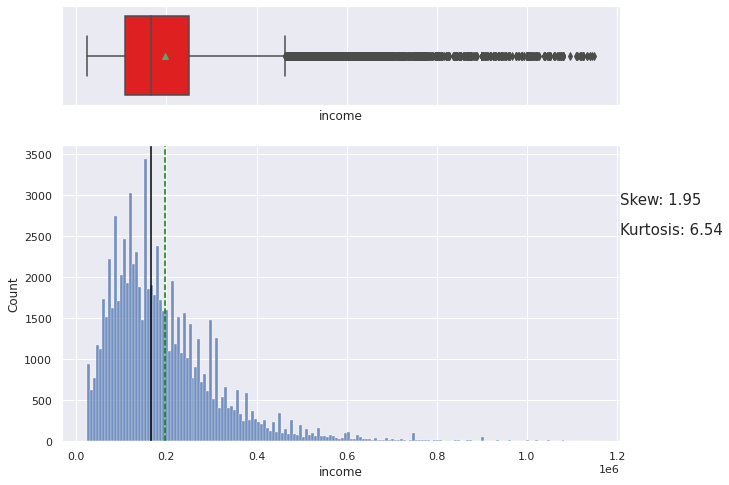

In [14]:
# Income is outrageously highly skewed. The plot is hardly interprateable except for the
# clearly visible outliers.
histogram_boxplot(df.income)
plt.show()

# To make the plot more interpretable we are filtering the data to obtain individuals with
# 1.15 million in Income and below. The plot is now more interpretable but still highly
# skewed to the right.
histogram_boxplot(df[df.income<1150000].income)
plt.show()

**Observations(Income):** Income is hightly skewed to the right with the few data points appearing as extreme outliers. This is clearly show with the plot and the skew value of 109.76.

**Observations(Filtered income):** On filtering income to only include data point withs income below 1.15 million the skew significantly drops to 1.95. The plots are now interpretable but still right skewed.

79.912 99.89
4282.32 5352.9


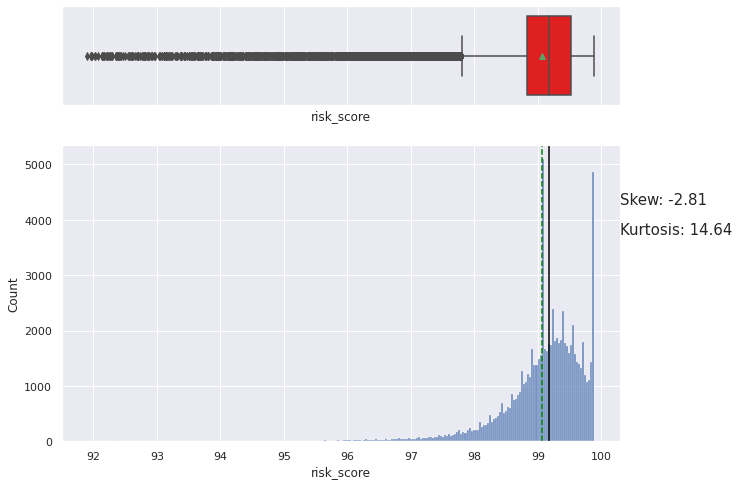

In [15]:
histogram_boxplot(df.risk_score)

30081.600000000002 37602
5297.040000000001 6621.3


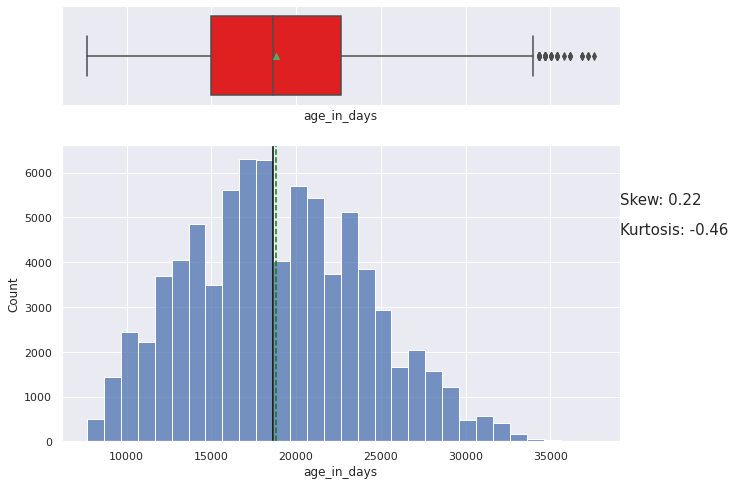

In [16]:
histogram_boxplot(df.age_in_days, bins=30)

**Observation(Age):**

- Age is normally distributed but with upper outliers.
- The mean and median of age is around 19000 day.
- Age is positively skewed.

48.0 60
11786.04 14732.55


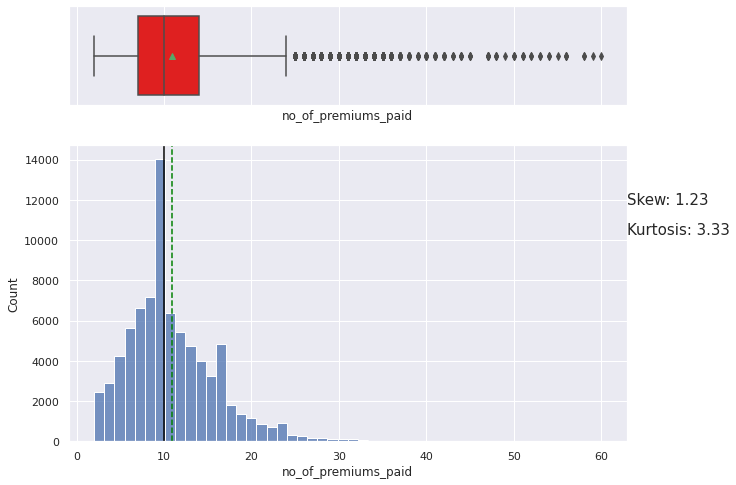

In [17]:
histogram_boxplot(df.no_of_premiums_paid, bins=50)

**Observation**
- The distribution on the no_of_premiums_paid till date is a normal distribution
- The median number is around 10 and the mean is ~12. Despite being normally distributed, the attributes values are is skewed to the right, but there are upper outliers.


48000.0 60000
15634.920000000002 19543.65


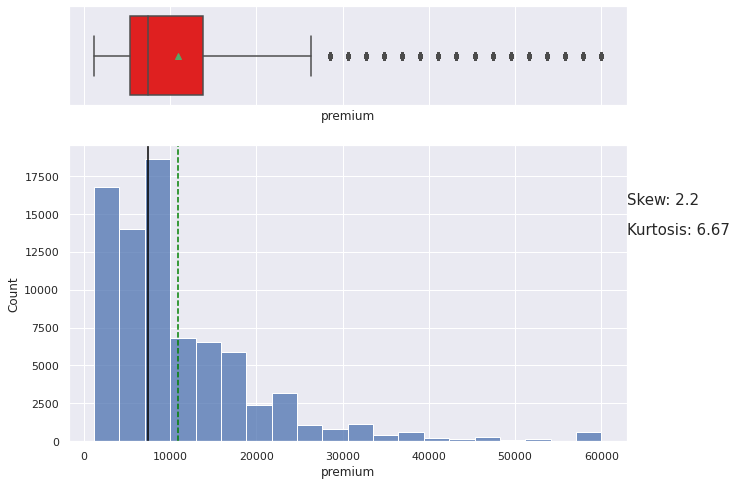

In [18]:
histogram_boxplot(df.premium, bins=20)

**Observations (Premium):**
- Right skewed with right outliers.

3.2 4
16980.600000000002 21225.75


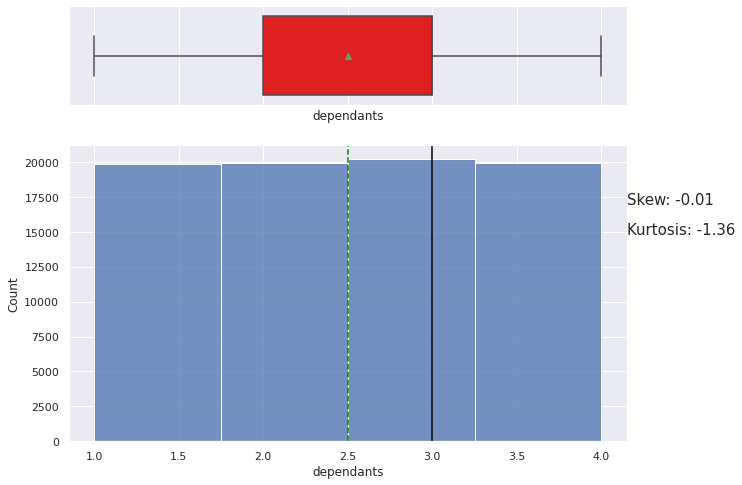

In [19]:
histogram_boxplot(df.dependants, bins=4)

**Observation**

The proportion of customers with 1,2,3 and 4 dependents is the same.

<AxesSubplot:>

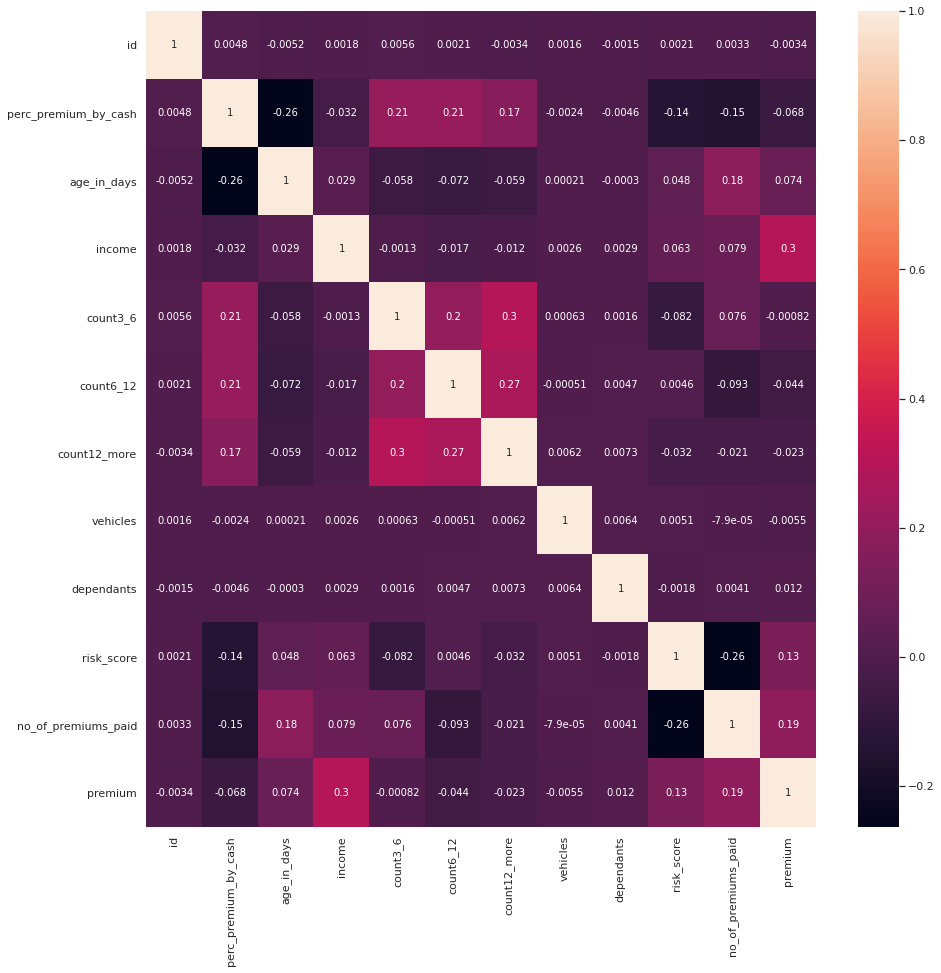

In [20]:
plt.figure(figsize=(15,15))
sns.heatmap(df.corr(), annot=True)

**Observations(correlation):**

- There are no numerical attributes that are highly correlated, be it negative or positive.

- It is, however, important to note the following attributes with slight correlation:
    - premium vs income: 0.3 - it is sensible to have this correlation presuming that high income earners will likely pay more premium.
    - no_of_premiums_paid vs premium: 0.19
    - The correlation between late payment classes is also relateable in the sense that an individual who has delayed for 3-6 months will likely delay to 6-12 and even beyound 12 months.
    - There is also a slight correlation between perc_premium_by_cash and the late payment.
    - There is also a slight negative correlation between no_of_premiums_paid and risk score (-0.26) worthnoting. 

default                  0         1
sourcing_channel                    
A                 0.054458  0.945542
B                 0.064559  0.935441
C                 0.075006  0.924994
D                 0.083874  0.916126
E                 0.075534  0.924466


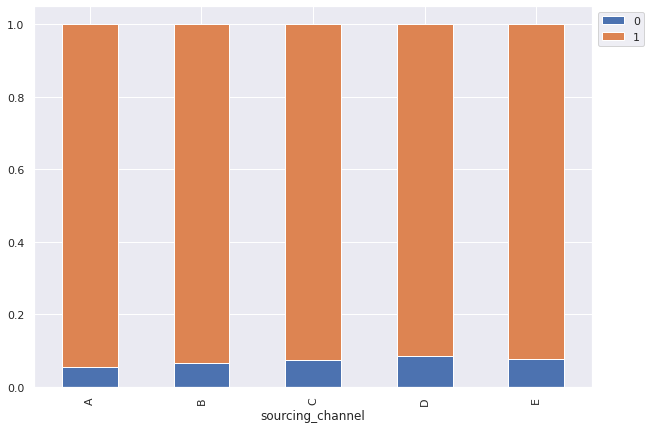

In [21]:
# Default status across sourcing channels
tab1 = pd.crosstab(df.sourcing_channel, df.default, margins=True)
tab2 = pd.crosstab(df.sourcing_channel, df.default, margins=False, normalize='index')
tab2.plot(kind='bar',stacked=True,figsize=(10,7))
print(tab2)
plt.legend(loc='lower left', frameon=False)
plt.legend(loc="upper left", bbox_to_anchor=(1,1));

**Observations (Sourcing channel)**

- Sourcing Channels tends to have varying impact on default status..

- Customers sourced from Channel A have the lowest chance of Defaulting 
- Customers sourced from Channel D and E have the higher Chance of Defaulting as compared to Channel A 
- Customers sourced from D Channel have the highest chance of Defaulting, followed by those from channels C & E, whose risk of Defaulting seems to be the same, followed by those from B, while Customers from A have the lowest risk of Defaulting

default                0         1
marital_status                    
0               0.064224  0.935776
1               0.060948  0.939052


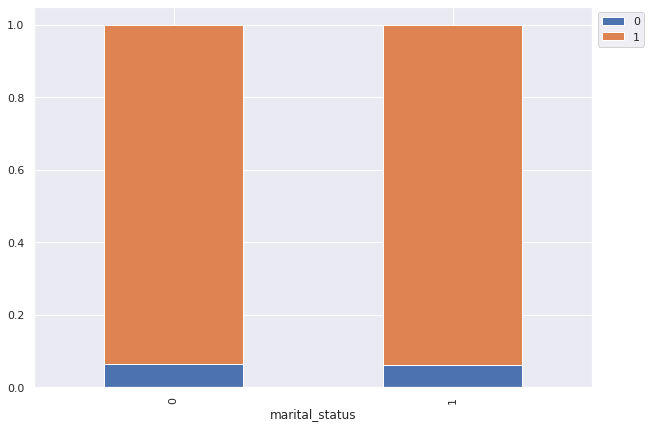

In [22]:
# Default status across marital status
tab1 = pd.crosstab(df.marital_status, df.default, margins=True)
tab2 = pd.crosstab(df.marital_status, df.default, margins=False, normalize='index')
tab2.plot(kind='bar',stacked=True,figsize=(10,7))
print(tab2)
plt.legend(loc='lower left', frameon=False)
plt.legend(loc="upper left", bbox_to_anchor=(1,1));

- Marital Status doesn’t seem to have any impact on the whether a customer defauls or not, that is, similar proportion of defaulters exists between the married and the unmarried classes. 
- Most of the customers are none defaulters in both classes.

default           0         1
residence                    
Rural      0.063088  0.936912
Urban      0.062263  0.937737


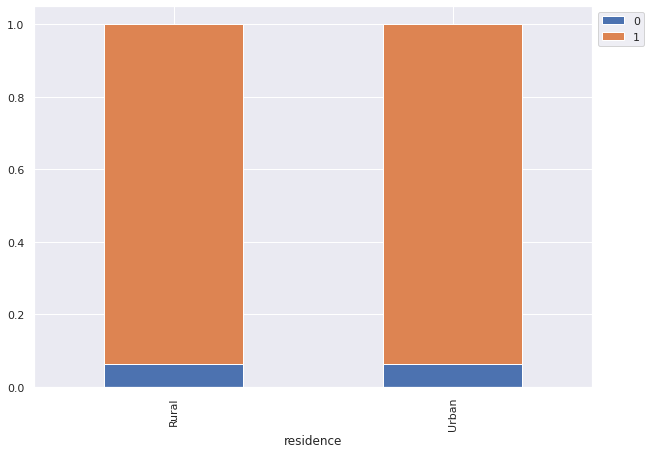

In [23]:
# Default status across residence type!
tab1 = pd.crosstab(df.residence, df.default, margins=True)
tab2 = pd.crosstab(df.residence, df.default, margins=False, normalize='index')
tab2.plot(kind='bar',stacked=True,figsize=(10,7))
print(tab2)
plt.legend(loc='lower left', frameon=False)
plt.legend(loc="upper left", bbox_to_anchor=(1,1));

- Residence doesn’t seem to have any significant on chances of default or otherwise.

In [24]:
from matplotlib.ticker import PercentFormatter

In [25]:
# Assign our dataframe from part 1 into df2 just convenience of rememberance.
df2 = df.copy()

In [26]:
# Tranform variable: Convert age in days to age in years as age
df2["age"] = df2["age_in_days"].apply(lambda x:round(x/365))

# Drop age_in_days and id. id is just equivalent to panda's default index
df2.drop(["age_in_days", "id"], axis=1, inplace=True)

In [27]:
df2.head()

,perc_premium_by_cash,income,count3_6,count6_12,count12_more,marital_status,vehicles,dependants,accomodation,risk_score,no_of_premiums_paid,sourcing_channel,residence,premium,default,age
0,0.317,90050,0,0,0,0,3,3,1,98.810,8,A,Rural,5400,1,31
1,0.000,156080,0,0,0,1,3,1,1,99.066,3,A,Urban,11700,1,83
2,0.015,145020,1,0,0,0,1,1,1,99.170,14,C,Urban,18000,1,44
3,0.000,187560,0,0,0,1,1,1,0,99.370,13,A,Urban,13800,1,65
4,0.888,103050,7,3,4,0,2,1,0,98.800,15,A,Urban,7500,0,53


In [28]:
# Add new variable: income groups
# pandas cut function that can be used to group data in a convenient way

df2["income_groups"] = pd.cut(df2.income, bins=[0, 1e5, 2e5, 3e5, 4e5, 5e5, 6e5, df2.income.max()],\
       labels=["Under100K","100K-200K", "200K-300K", "300K-400K",\
               "400K-500K","500K-600K", "Above600K"])

Under100K    0.213179
100K-200K    0.398720
200K-300K    0.214983
300K-400K    0.104317
400K-500K    0.033549
500K-600K    0.014715
Above600K    0.020538
Name: income_groups, dtype: float64


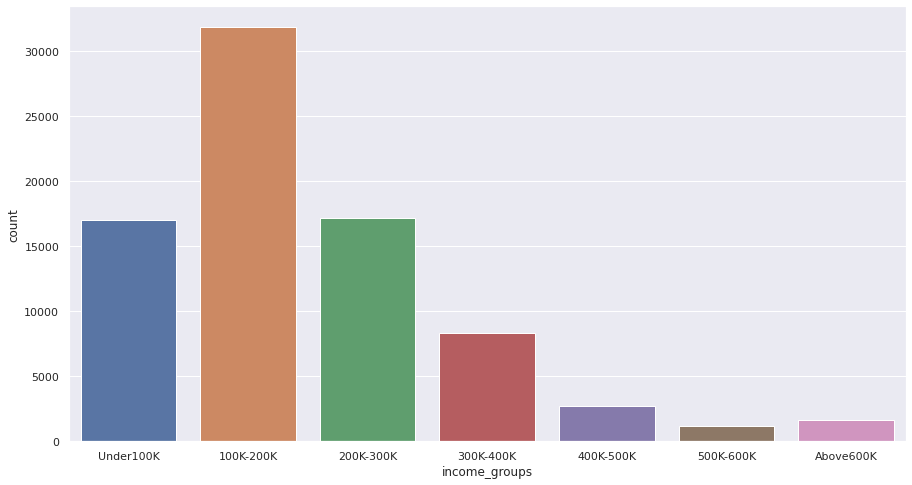

In [29]:
# Distribution of data across age groups
income_g = df2.income_groups.value_counts(sort=False, normalize=True)
print(income_g)

plt.figure(figsize=(15,8))
sns.countplot(x='income_groups', data=df2)
plt.show()

**Remark**
- ~21% of the individuals earns below 100K and only ~2% earning above 600 thousand. Majority of the people (39.87%) earns income of between 100K and 200K.

In [30]:
print(income_g.cumsum()) # cumulative sum

Under100K    0.213179
100K-200K    0.611899
200K-300K    0.826882
300K-400K    0.931199
400K-500K    0.964748
500K-600K    0.979462
Above600K    1.000000
Name: income_groups, dtype: float64


**Remark**
- ~21% of the individuals earns below 100K, ~93% below less than 400K and ~97% earns below 600K.

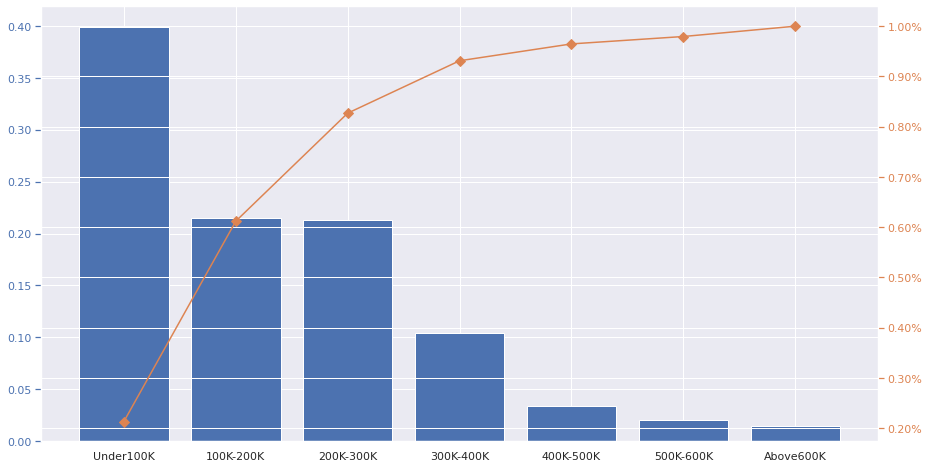

In [31]:
# Pareto chart for income groups
x = income_g.sort_values(ascending=False)
cumulative = income_g.cumsum()

fig, ax = plt.subplots(figsize=(15,8))
ax.bar(income_g.index, x, color="C0")
ax2 = ax.twinx()
ax2.plot(income_g.index, cumulative, color="C1", marker="D", ms=7)
ax2.yaxis.set_major_formatter(PercentFormatter())

ax.tick_params(axis="y", colors="C0")
ax2.tick_params(axis="y", colors="C1")
plt.show()

In [32]:
# Add new variable- generate agegroups using pandas cut function as used before
df2["age_groups"] = pd.cut(df2.age, bins=[0,20,40,60,80,df2.age.max()],\
       right=True, labels=["Under20","Age20-40", "Age40-60", "Age60-80","Above80"])

Under20     0.000000
Age20-40    0.240141
Age40-60    0.483113
Age60-80    0.251124
Above80     0.025622
Name: age_groups, dtype: float64


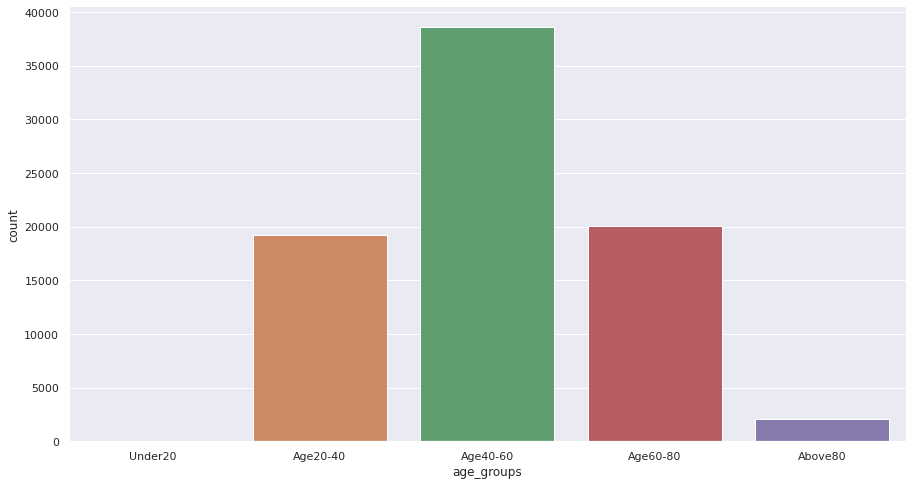

In [33]:
# Distribution of individuals across age groups
age_g = df2.age_groups.value_counts(sort=False, normalize=True)
print(age_g)

plt.figure(figsize=(15,8))
sns.countplot(x='age_groups', data=df2)
plt.show()

**Remark(s):**
- There is no one amongst the customers who is under 20 years of age. Majority of the customers making ~48% of all falls on the 40-60 age category. Only 2.6% of the customers are above 80.

In [34]:
print(age_g.cumsum()) # cumulative sum

Under20     0.000000
Age20-40    0.240141
Age40-60    0.723254
Age60-80    0.974378
Above80     1.000000
Name: age_groups, dtype: float64


**Remark**

- There is no one under 20, ~72% of the customers are under 60 and ~97% under 80.

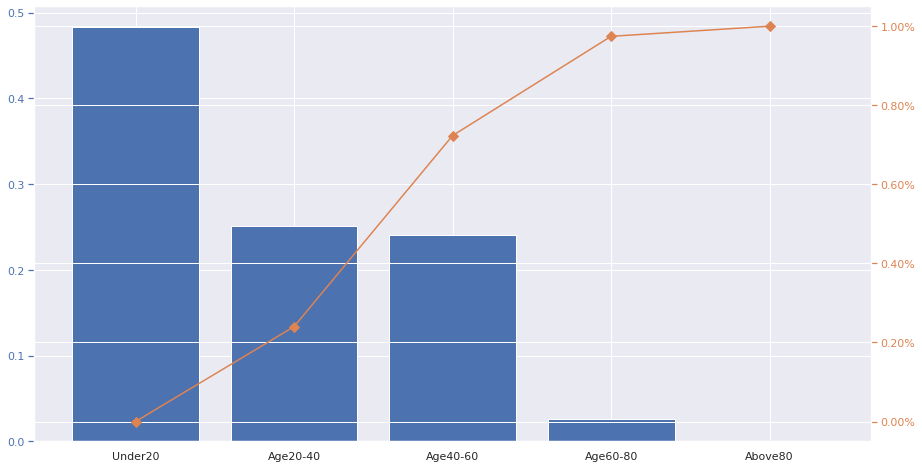

In [35]:
# Pareto chart for age groups
x = age_g.sort_values(ascending=False)
cumulative = age_g.cumsum()

fig, ax = plt.subplots(figsize=(15,8))
ax.bar(age_g.index, x, color="C0")
ax2 = ax.twinx()
ax2.plot(age_g.index, cumulative, color="C1", marker="D", ms=7)
ax2.yaxis.set_major_formatter(PercentFormatter())

ax.tick_params(axis="y", colors="C0")
ax2.tick_params(axis="y", colors="C1")
plt.show()

residence         Rural     Urban
income_groups                    
Under100K      0.402690  0.597310
100K-200K      0.394233  0.605767
200K-300K      0.397041  0.602959
300K-400K      0.396759  0.603241
400K-500K      0.389324  0.610676
500K-600K      0.389787  0.610213
Above600K      0.390854  0.609146


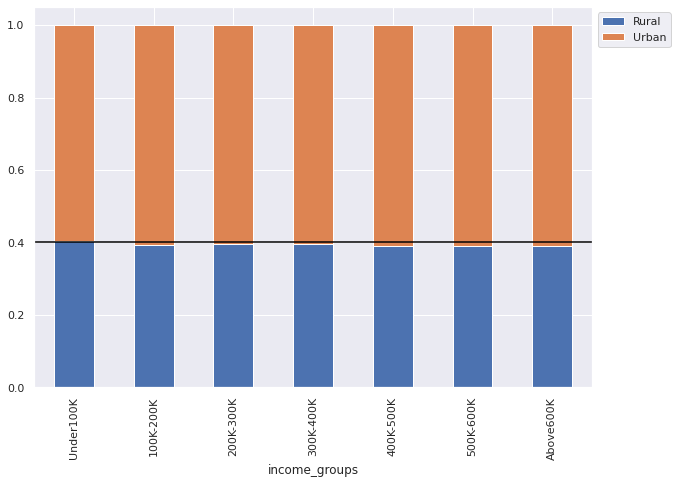

In [36]:
# Default status across sourcing channels
tab1 = pd.crosstab(df2.income_groups, df2.residence, margins=True)
tab2 = pd.crosstab(df2.income_groups, df2.residence, margins=False, normalize='index')
tab2.plot(kind='bar',stacked=True,figsize=(10,7))
print(tab2)
plt.legend(loc='lower left', frameon=False)
plt.axhline(0.4, color='black')
plt.legend(loc="upper left", bbox_to_anchor=(1,1));

**Remark:** Around 60% of the customers stays in urban across all income groups. It is, however, notable that people of higher income class have a higher tendency of being in the urban than people in the low income class.

vehicles              1         2         3
income_groups                              
Under100K      0.335370  0.330259  0.334371
100K-200K      0.336286  0.329533  0.334181
200K-300K      0.331450  0.340595  0.327955
300K-400K      0.332293  0.330852  0.336855
400K-500K      0.355356  0.320269  0.324375
500K-600K      0.330213  0.316596  0.353191
Above600K      0.324390  0.349390  0.326220


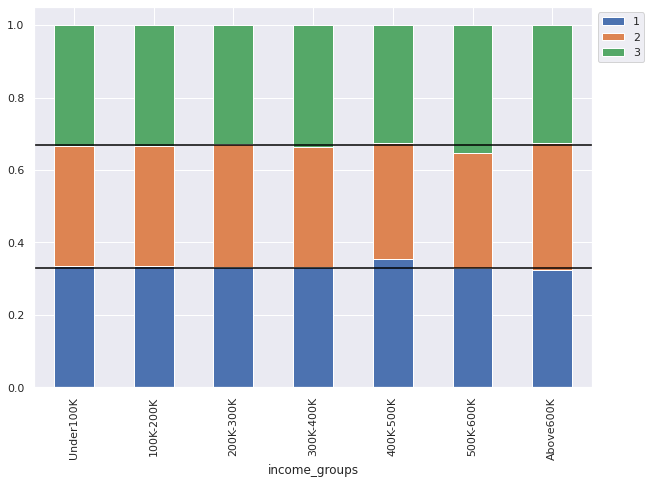

In [37]:
# Default status across sourcing channels
tab1 = pd.crosstab(df2.income_groups, df2.vehicles, margins=True)
tab2 = pd.crosstab(df2.income_groups, df2.vehicles, margins=False, normalize='index')
tab2.plot(kind='bar',stacked=True,figsize=(10,7))
print(tab2)
plt.legend(loc='lower left', frameon=False)
plt.axhline(0.67, color='black')
plt.axhline(0.33, color='black')
plt.legend(loc="upper left", bbox_to_anchor=(1,1));

**Remark:** There is no clear trend of number of vehicles across income classes. In each income class, around 30% of the customers have 1, 2 and 3 vehicles.

sourcing_channel         A         B         C         D         E
income_groups                                                     
Under100K         0.691359  0.160254  0.097456  0.047700  0.003231
100K-200K         0.553221  0.211533  0.146550  0.083043  0.005653
200K-300K         0.470496  0.223510  0.177783  0.117901  0.010310
300K-400K         0.434214  0.223409  0.184754  0.144058  0.013565
400K-500K         0.376260  0.258679  0.200821  0.149683  0.014558
500K-600K         0.378723  0.248511  0.194894  0.167660  0.010213
Above600K         0.368293  0.223171  0.217073  0.171341  0.020122


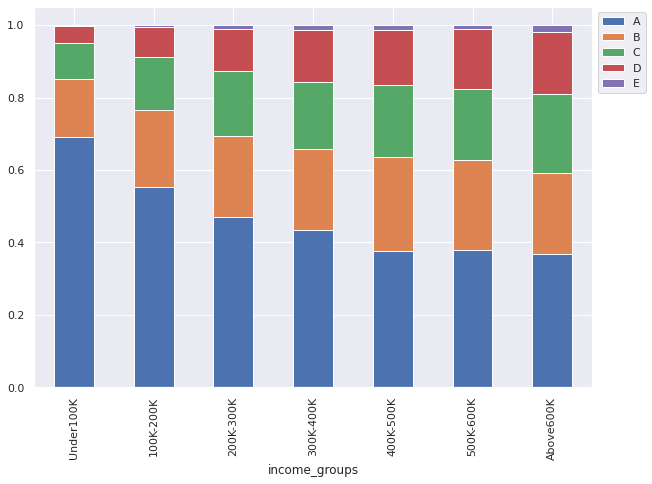

In [38]:
# Default status across sourcing channels
tab1 = pd.crosstab(df2.income_groups, df2.sourcing_channel, margins=True)
tab2 = pd.crosstab(df2.income_groups, df2.sourcing_channel, margins=False, normalize='index')
tab2.plot(kind='bar',stacked=True,figsize=(10,7))
print(tab2)
plt.legend(loc='lower left', frameon=False)
plt.legend(loc="upper left", bbox_to_anchor=(1,1));

**Observations:**
- There exist a relationship between income and sourcing channel.
- As we move up the income class ladder, the number of people sourced by channel A grows smaller and smaller.
- The number of people sourced from the other channels (B, C, D and E) increases across income classes.

In [39]:
income_groups_and_age = df2[['income_groups','age']].groupby(['income_groups']).mean().reset_index()
print(income_groups_and_age)

  income_groups        age
0     Under100K  49.132115
1     100K-200K  51.461415
2     200K-300K  52.279024
3     300K-400K  53.982233
4     400K-500K  54.496081
5     500K-600K  55.193191
6     Above600K  53.754268


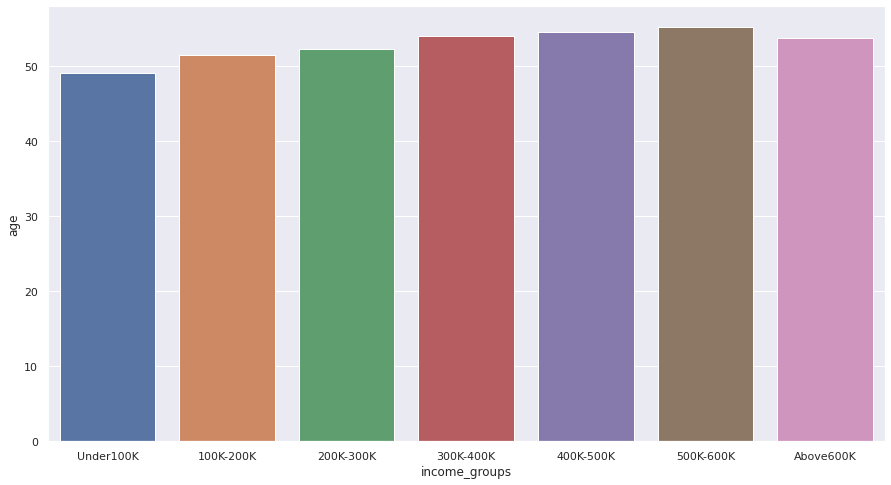

In [40]:
plt.figure(figsize=(15,8))
sns.barplot(x='income_groups', y='age', data=income_groups_and_age)
plt.show()

**Remark:** As age increases, income also increases, as expected. This is a general trend.

In [41]:
income_groups_and_premium = df2[['income_groups','premium']].groupby(['income_groups']).mean().reset_index()
income_groups_and_premium

,income_groups,premium
0,Under100K,4384.374082
1,100K-200K,8059.012532
2,200K-300K,13091.739966
3,300K-400K,18093.025210
4,400K-500K,23759.126540
5,500K-600K,29584.851064
6,Above600K,41009.085366


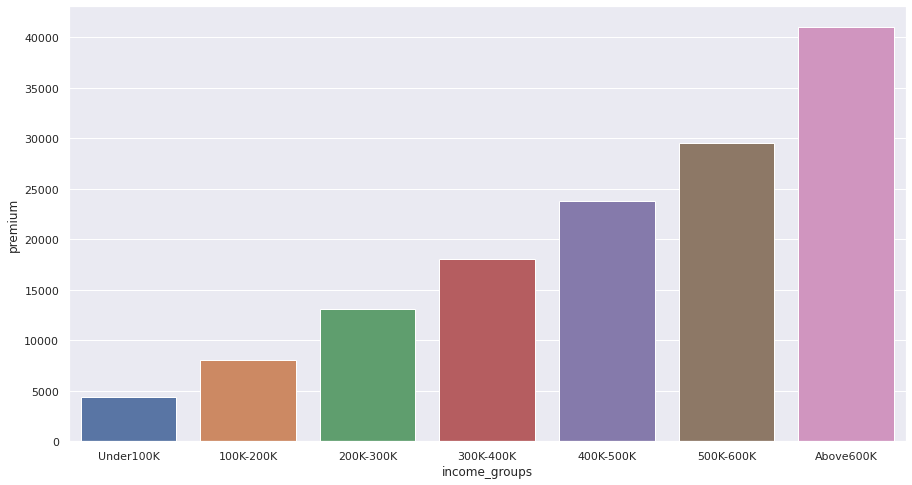

In [42]:
plt.figure(figsize=(15,8))
sns.barplot(x='income_groups', y='premium', data=income_groups_and_premium)
plt.show()

**Remark:** Higher income earners pays more premium than low income earners (as expected).

In [43]:
income_groups_and_cash = df2[['income_groups','perc_premium_by_cash']].groupby(['income_groups']).mean().reset_index()
income_groups_and_cash

,income_groups,perc_premium_by_cash
0,Under100K,0.379262
1,100K-200K,0.318519
2,200K-300K,0.282890
3,300K-400K,0.256217
4,400K-500K,0.271313
5,500K-600K,0.273282
6,Above600K,0.280918


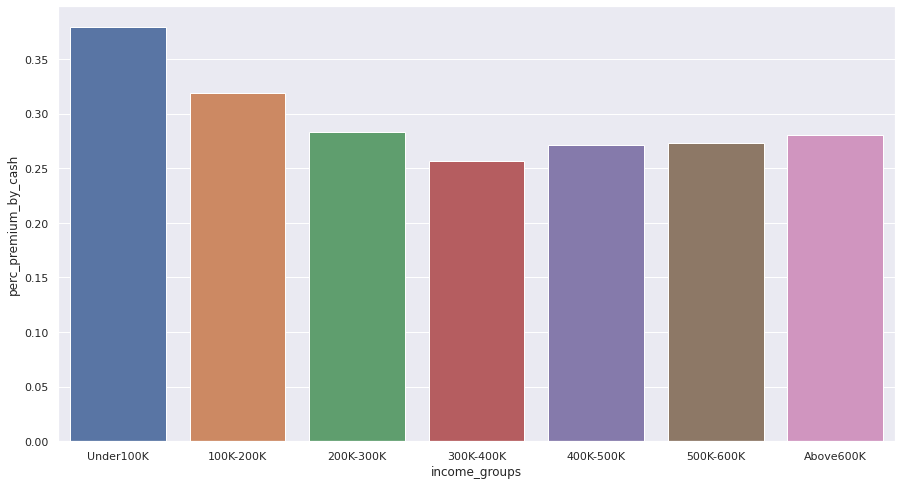

In [44]:
plt.figure(figsize=(15,8))
sns.barplot(x='income_groups', y='perc_premium_by_cash', data=income_groups_and_cash)
plt.show()

**Remark:** Of the people paying by cash, majority are low income earners. As income increases, customers moves away from cash payment.

default               0         1
income_groups                    
Under100K      0.088938  0.911062
100K-200K      0.066240  0.933760
200K-300K      0.047067  0.952933
300K-400K      0.037815  0.962185
400K-500K      0.041433  0.958567
500K-600K      0.045957  0.954043
Above600K      0.053049  0.946951


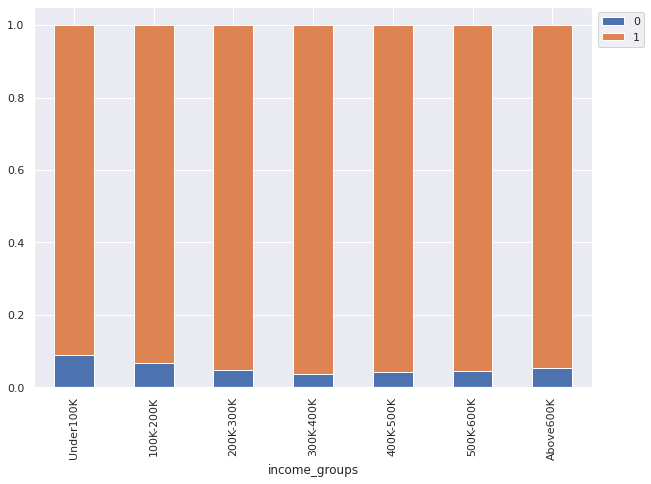

In [45]:
# Default status across sourcing channels
tab1 = pd.crosstab(df2.income_groups, df2.default, margins=True)
tab2 = pd.crosstab(df2.income_groups, df2.default, margins=False, normalize='index')
tab2.plot(kind='bar',stacked=True,figsize=(10,7))
print(tab2)
plt.legend(loc='lower left', frameon=False)
plt.legend(loc="upper left", bbox_to_anchor=(1,1));

**Observation:** More defaulters are low income earners.

age_groups     Age20-40  Age40-60  Age60-80   Above80
income_groups                                        
Under100K      0.376314  0.333607  0.251131  0.038947
100K-200K      0.259556  0.462043  0.250259  0.028142
200K-300K      0.176909  0.571329  0.234170  0.017592
300K-400K      0.109724  0.611164  0.262665  0.016447
400K-500K      0.094065  0.609929  0.290407  0.005599
500K-600K      0.086809  0.597447  0.305532  0.010213
Above600K      0.122561  0.581098  0.283537  0.012805


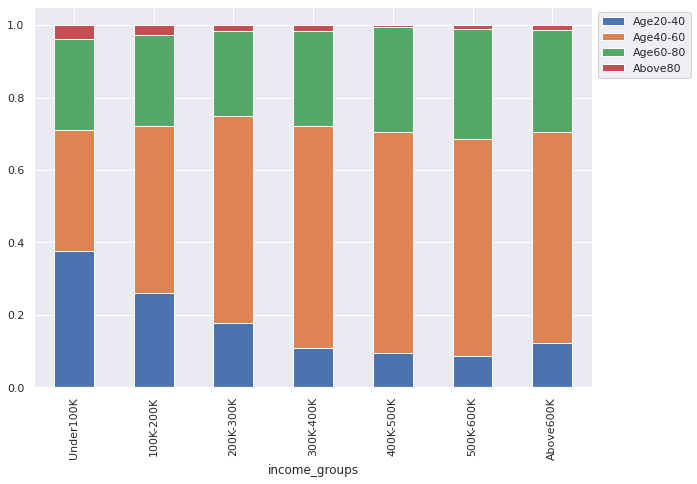

In [46]:
# Default status across sourcing channels
tab1 = pd.crosstab(df2.income_groups, df2.age_groups, margins=True)
tab2 = pd.crosstab(df2.income_groups, df2.age_groups, margins=False, normalize='index')
tab2.plot(kind='bar',stacked=True,figsize=(10,7))
print(tab2)
plt.legend(loc='lower left', frameon=False)
plt.legend(loc="upper left", bbox_to_anchor=(1,1));

**Observation:** Older people earns more.

default            0         1
age_groups                    
Age20-40    0.089695  0.910305
Age40-60    0.067344  0.932656
Age60-80    0.031566  0.968434
Above80     0.022972  0.977028


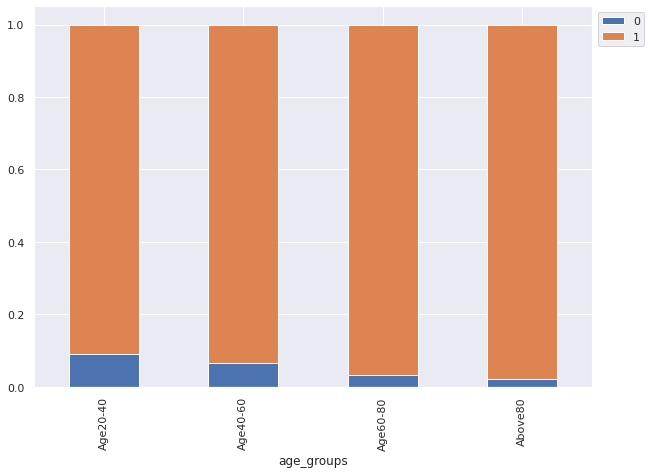

In [47]:
# Default status across sourcing channels
tab1 = pd.crosstab(df2.age_groups, df2.default, margins=True)
tab2 = pd.crosstab(df2.age_groups, df2.default, margins=False, normalize='index')
tab2.plot(kind='bar',stacked=True,figsize=(10,7))
print(tab2)
plt.legend(loc='lower left', frameon=False)
plt.legend(loc="upper left", bbox_to_anchor=(1,1));

**Observation:** Younger customers default more than older people.

In [48]:
income_groups_and_cash = df2[['age_groups','perc_premium_by_cash']].groupby(['age_groups']).mean().reset_index()
income_groups_and_cash

,age_groups,perc_premium_by_cash
0,Under20,NaN
1,Age20-40,0.420580
2,Age40-60,0.325038
3,Age60-80,0.211763
4,Above80,0.120219


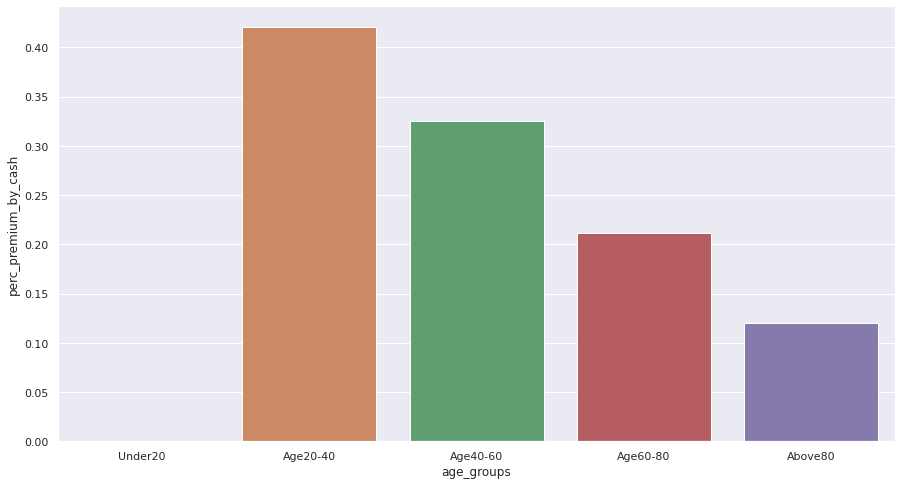

In [49]:
plt.figure(figsize=(15,8))
sns.barplot(x='age_groups', y='perc_premium_by_cash', data=income_groups_and_cash)
plt.show()

residence      Rural     Urban
age_groups                    
Age20-40    0.396224  0.603776
Age40-60    0.398388  0.601612
Age60-80    0.393557  0.606443
Above80     0.396383  0.603617


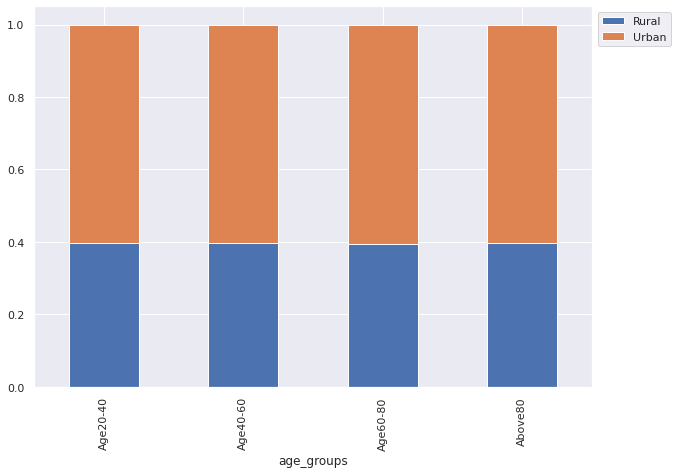

In [50]:
# Default status across sourcing channels
tab1 = pd.crosstab(df2.age_groups, df2.residence, margins=True)
tab2 = pd.crosstab(df2.age_groups, df2.residence, margins=False, normalize='index')
tab2.plot(kind='bar',stacked=True,figsize=(10,7))
print(tab2)
plt.legend(loc='lower left', frameon=False)
plt.legend(loc="upper left", bbox_to_anchor=(1,1));

**Observation:** Roughly equal number of people (60%) across age groups stays in the urban

accomodation         0         1
age_groups                      
Age20-40      0.494837  0.505163
Age40-60      0.499974  0.500026
Age60-80      0.498778  0.501222
Above80       0.510264  0.489736


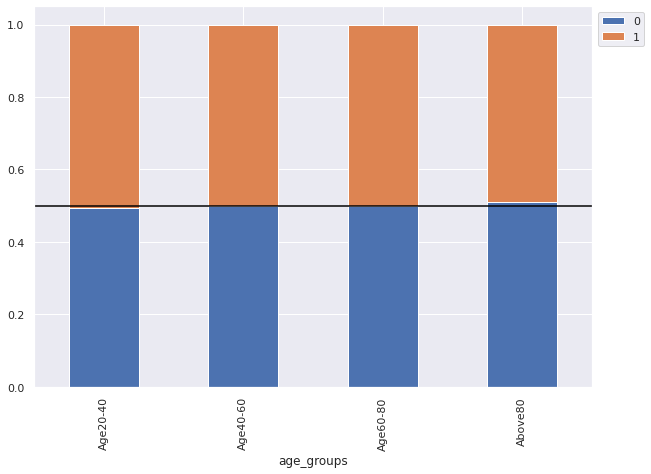

In [51]:
# Default status across sourcing channels
tab1 = pd.crosstab(df2.age_groups, df2.accomodation, margins=True)
tab2 = pd.crosstab(df2.age_groups, df2.accomodation, margins=False, normalize='index')
tab2.plot(kind='bar',stacked=True,figsize=(10,7))
print(tab2)
plt.axhline(0.5, color='black')
plt.legend(loc='lower left', frameon=False)
plt.legend(loc="upper left", bbox_to_anchor=(1,1));

**Observation:** There is no clear relation between accomodation type and the age groups.

marital_status         0         1
age_groups                        
Age20-40        0.501147  0.498853
Age40-60        0.501659  0.498341
Age60-80        0.501920  0.498080
Above80         0.490714  0.509286


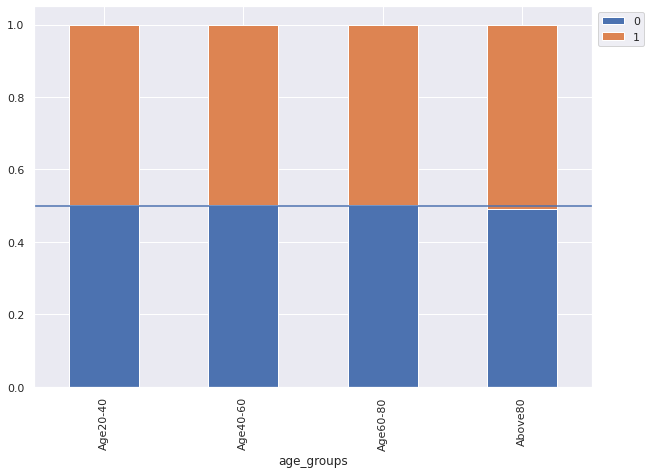

In [52]:
# Default status across sourcing channels
tab1 = pd.crosstab(df2.age_groups, df2.marital_status, margins=True)
tab2 = pd.crosstab(df2.age_groups, df2.marital_status, margins=False, normalize='index')
tab2.plot(kind='bar',stacked=True,figsize=(10,7))
print(tab2)
plt.legend(loc='lower left', frameon=False)
plt.axhline(0.5)
plt.legend(loc="upper left", bbox_to_anchor=(1,1));

**Observation:** More people are married at older age.

In [53]:
# Late premium - establish people who have been late for at least 3 months
df2['late_pay'] = df2.count3_6 + df2.count6_12 + df2.count12_more

# late is 1 and 0 otherwise
df2.loc[df2['late_pay']>0, 'late_pay'] = 1

df2.late_pay = df2.late_pay.astype('category')

In [54]:
df2.late_pay.value_counts(normalize=True)

# 79.7% of the customers have at least delayed payment for at least three months.

0    0.797027
1    0.202973
Name: late_pay, dtype: float64

late_pay           0         1
age_groups                    
Age20-40    0.760534  0.239466
Age40-60    0.777697  0.222303
Age60-80    0.859123  0.140877
Above80     0.894917  0.105083


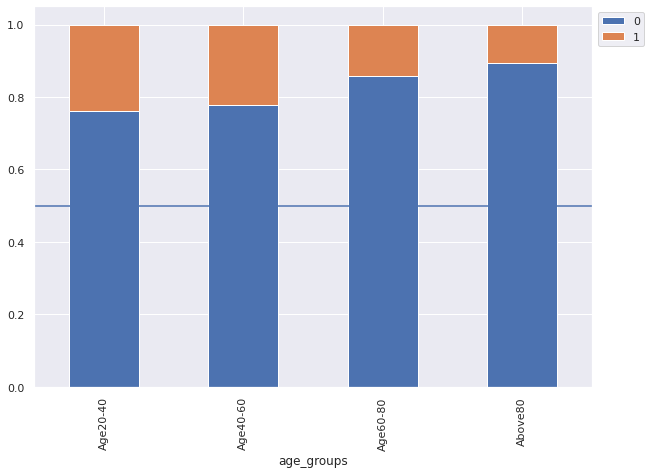

In [55]:
# Default status across sourcing channels
tab1 = pd.crosstab(df2.age_groups, df2.late_pay, margins=True)
tab2 = pd.crosstab(df2.age_groups, df2.late_pay, margins=False, normalize='index')
tab2.plot(kind='bar',stacked=True,figsize=(10,7))
print(tab2)
plt.legend(loc='lower left', frameon=False)
plt.axhline(0.5)
plt.legend(loc="upper left", bbox_to_anchor=(1,1));

**Observation:** Older people are less likely to pay late than younger customers.

late_pay              0         1
income_groups                    
Under100K      0.773777  0.226223
100K-200K      0.790728  0.209272
200K-300K      0.812140  0.187860
300K-400K      0.830012  0.169988
400K-500K      0.810004  0.189996
500K-600K      0.811915  0.188085
Above600K      0.803049  0.196951


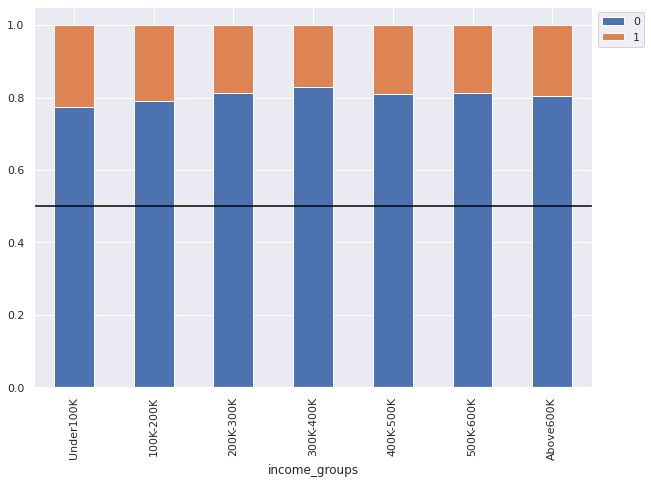

In [56]:
# Default status across sourcing channels
tab1 = pd.crosstab(df2.income_groups, df2.late_pay, margins=True)
tab2 = pd.crosstab(df2.income_groups, df2.late_pay, margins=False, normalize='index')
tab2.plot(kind='bar',stacked=True,figsize=(10,7))
print(tab2)
plt.legend(loc='lower left', frameon=False)
plt.axhline(0.5, color='black')
plt.legend(loc="upper left", bbox_to_anchor=(1,1));

late_pay         0         1
default                     
0         0.372349  0.627651
1         0.825382  0.174618


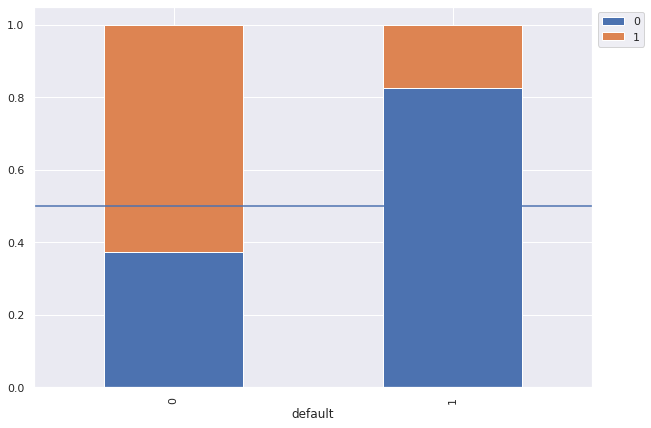

In [57]:
# Default status across sourcing channels
tab1 = pd.crosstab(df2.default, df2.late_pay, margins=True)
tab2 = pd.crosstab(df2.default, df2.late_pay, margins=False, normalize='index')
tab2.plot(kind='bar',stacked=True,figsize=(10,7))
print(tab2)
plt.legend(loc='lower left', frameon=False)
plt.axhline(0.5)
plt.legend(loc="upper left", bbox_to_anchor=(1,1));

**Observation:** As expected, majority of the customer with late repayment defaulted and majority of those who never delayed for more than 3 months, least defaulted.

In [58]:
income_groups_and_no = df2[['default','no_of_premiums_paid']].groupby(['default']).mean().reset_index()
income_groups_and_no

,default,no_of_premiums_paid
0,0,10.410364
1,1,10.894169


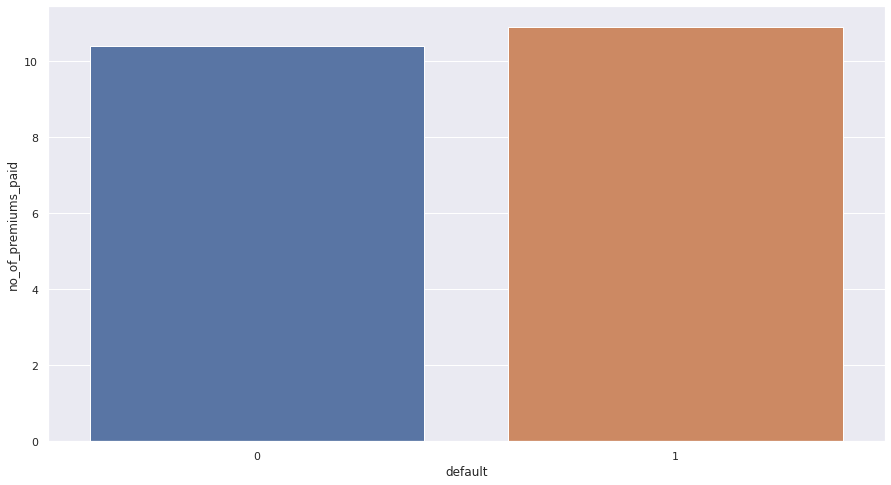

In [59]:
plt.figure(figsize=(15,8))
sns.barplot(x='default', y='no_of_premiums_paid', data=income_groups_and_no)
plt.show()

### Treating outliers

In [60]:
numerical_cols = list(df2.select_dtypes(np.number).columns)
print(numerical_cols)

['perc_premium_by_cash', 'income', 'count3_6', 'count6_12', 'count12_more', 'vehicles', 'dependants', 'risk_score', 'no_of_premiums_paid', 'premium', 'age']


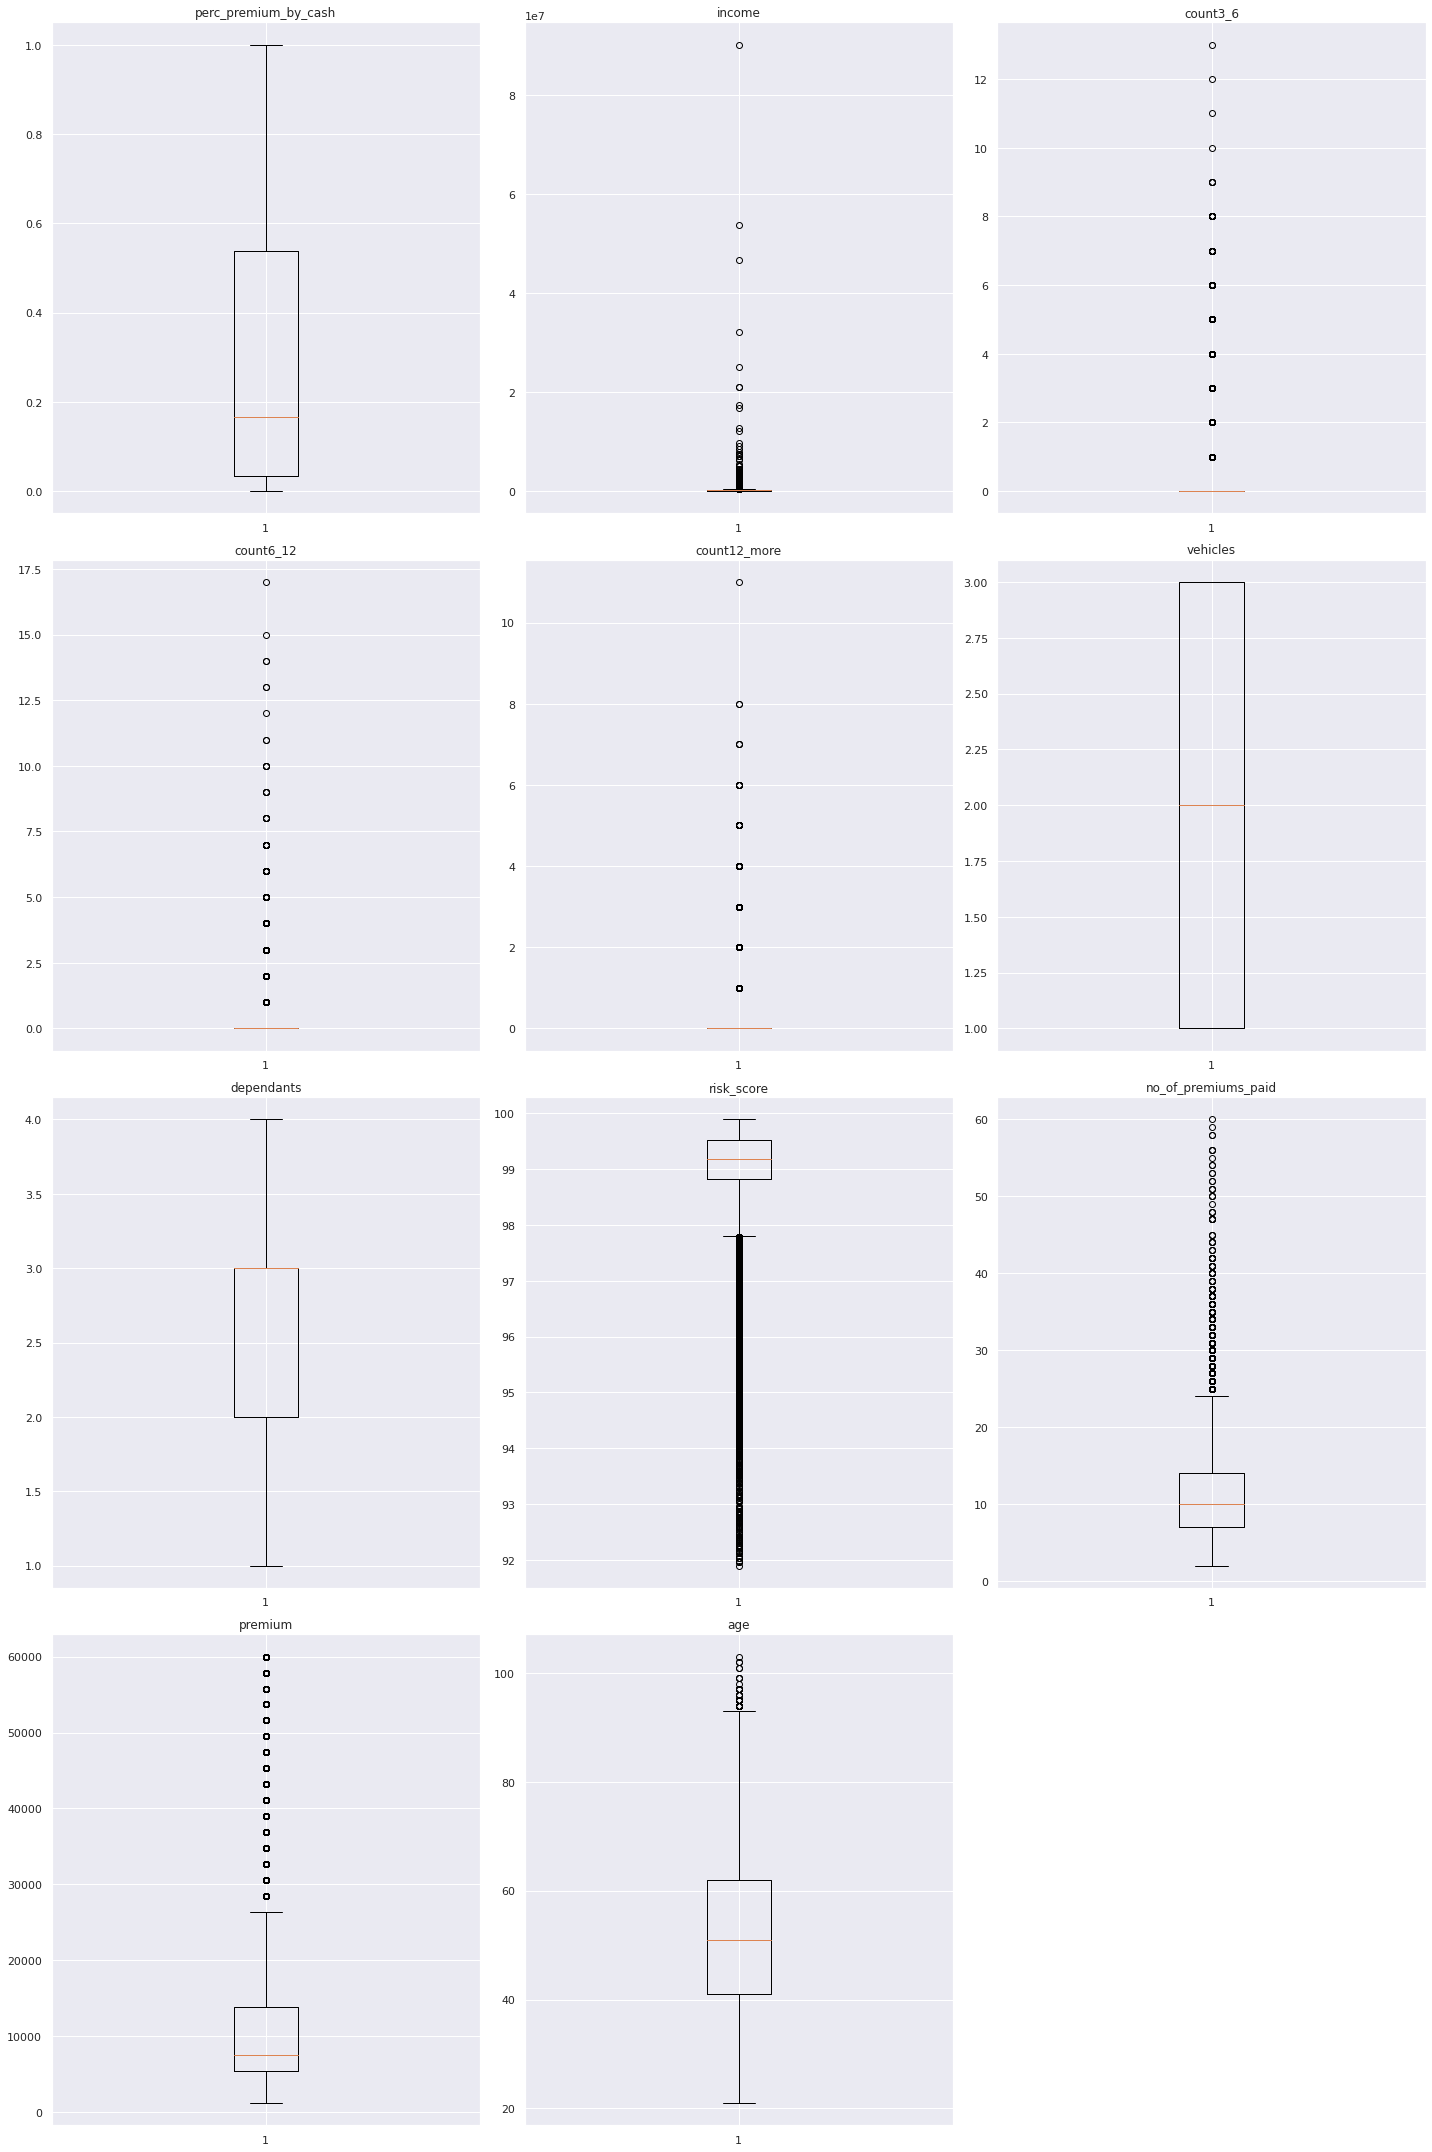

In [61]:
# outlier detection using boxplot
plt.figure(figsize=(20,30))
for i, variable in enumerate(numerical_cols):
    plt.subplot(4,3,i+1)
    plt.boxplot(df2[variable],whis=1.5)
    plt.tight_layout()
    plt.title(variable)
plt.show()

In [62]:
def treat_outliers(df,col):
    '''
    treats outliers in a varaible
    col: str, name of the numerical varaible
    df: data frame
    col: name of the column
    '''
    Q1=df[col].quantile(0.25) # 25th quantile
    Q3=df[col].quantile(0.75)  # 75th quantile
    IQR=Q3-Q1
    Lower_Whisker = Q1 - 1.5*IQR 
    Upper_Whisker = Q3 + 1.5*IQR
    df[col] = np.clip(df[col], Lower_Whisker, Upper_Whisker) # all the values samller than Lower_Whisker will be assigned value of Lower_whisker 
    # and all the values above upper_whishker will be assigned value of upper_Whisker 
    print(col, 'L_whisker: ', Lower_Whisker, 'U_whisker: ', Upper_Whisker)
    return df
    

In [63]:
df2_original = df2.copy()

In [64]:
# treating outliers for the following columns
col_list = [
    'income',
    'risk_score',
    'no_of_premiums_paid',
    'premium',
    'age'
]

for c in col_list:
    df2 = treat_outliers(df2,c)

income L_whisker:  -108110.0 U_whisker:  468210.0
risk_score L_whisker:  97.795 U_whisker:  100.55499999999999
no_of_premiums_paid L_whisker:  -3.5 U_whisker:  24.5
premium L_whisker:  -7200.0 U_whisker:  26400.0
age L_whisker:  9.5 U_whisker:  93.5


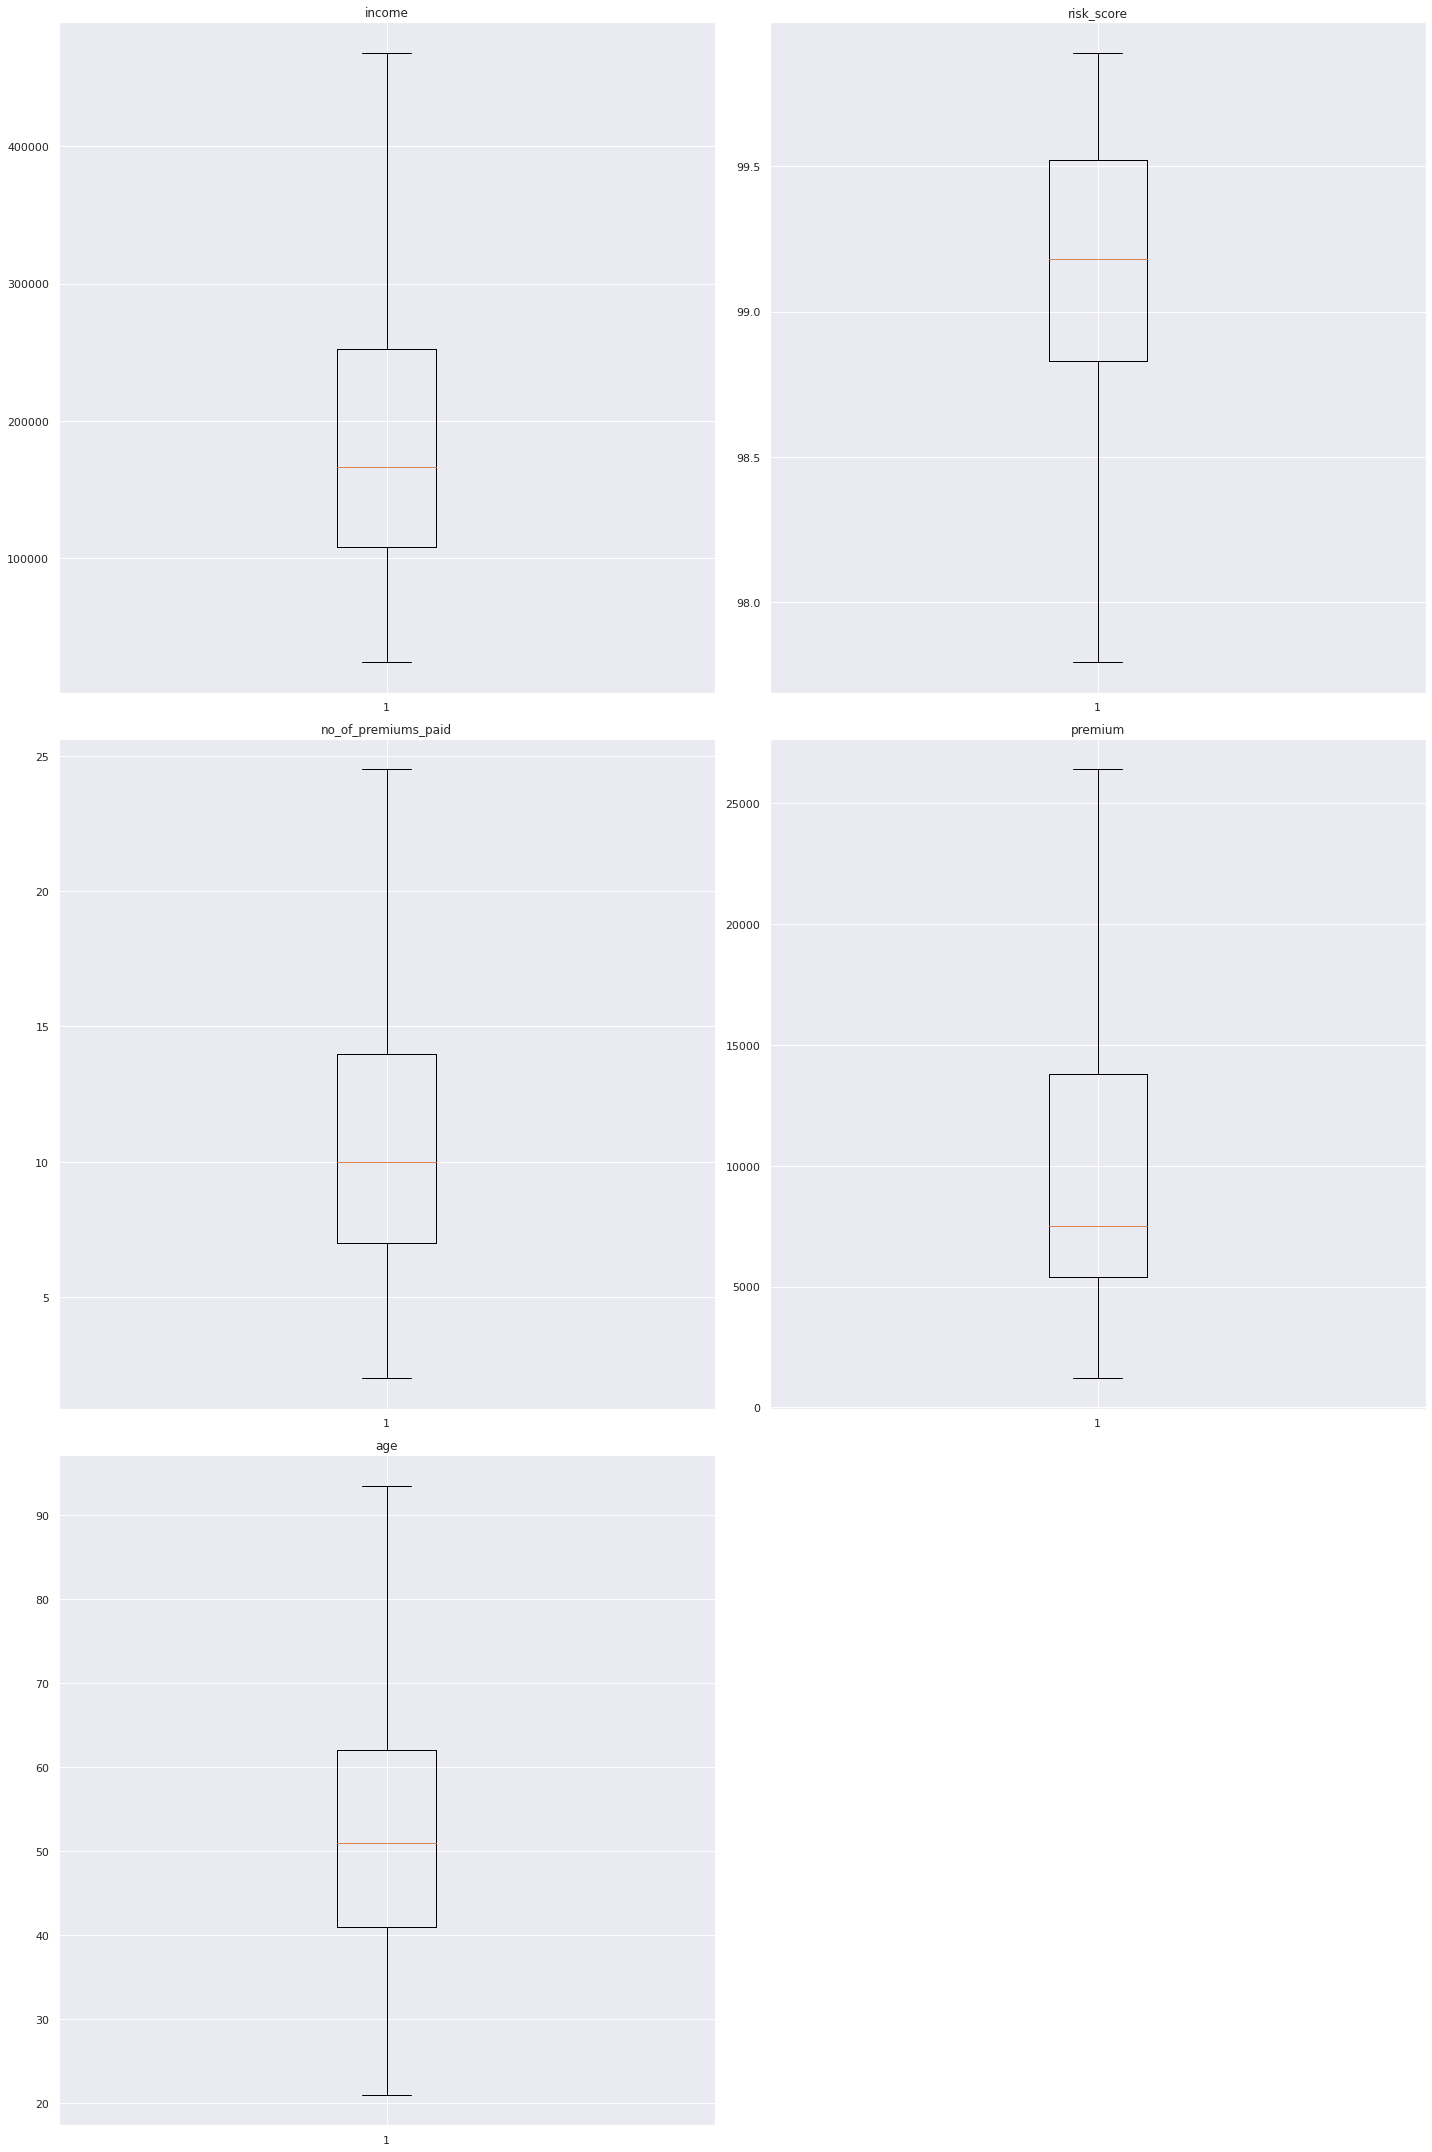

In [65]:
# Check that outliers has been treated boxplot
plt.figure(figsize=(20,30))
for i, variable in enumerate(col_list):
    plt.subplot(3,2,i+1)
    plt.boxplot(df2[variable],whis=1.5)
    plt.tight_layout()
    plt.title(variable)
plt.show()

In [66]:
def ConfusionMatrix(y_actual, pred, set1, save_as=None):
    """
    This function will be used throughout the project to generate Confusion Matrix.
    """
    plt.figure(figsize=(10,8))
    
    cm = confusion_matrix(y_actual,pred, labels=[1, 0])

    df_cm = pd.DataFrame(cm, index=["No","Yes"], columns=["No","Yes"])
    #percent = [np.round(i/np.sum(cm.flatten())*100,2) for i in cm.flatten()]
    percent = [df_cm.iloc[0,0]/sum(df_cm.iloc[0]),df_cm.iloc[0,1]/sum(df_cm.iloc[0]),\
              df_cm.iloc[1,0]/sum(df_cm.iloc[1]),df_cm.iloc[1,1]/sum(df_cm.iloc[1])]
    percent = [round(i,2) for i in percent]
    values = cm.flatten()
    labels = ["{}\n({}%)".format(i,j) for i, j in
                  zip(values,percent)]
    labels = np.array(labels).reshape(2,2)
    
    sns.heatmap(df_cm, annot= labels, fmt= "")
    
    plt.title("Confusion Matrix for {} set.".format(set1))
    plt.xlabel("Predicted Values")
    plt.ylabel("True Values")
    
    if save_as != None:
        plt.savefig("./images/{}".format(save_as))
    
    plt.show()
    
    print(set1,cm)
    
    return None

In [67]:
##  Function to calculate different metric scores of the model - Accuracy, Recall and Precision
def get_metrics_score(model,X_train, y_train, X_test, y_test ,flag=True, model_name=""):
    '''
    This function is used to make prediction and to determine model
    performance using metrics like: accuracy, precision, recall and f1.

    '''
    # defining an empty list to store train and test results
    score_list=[] 
    
    #Predicting on train and tests
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    
    #Accuracy of the model
    train_acc = model.score(X_train,y_train)
    test_acc = model.score(X_test,y_test)
    
    #Recall of the model
    train_recall = recall_score(y_train,pred_train,labels=[0, 1],pos_label=0)
    test_recall = recall_score(y_test,pred_test,labels=[0 ,1],pos_label=0)
    
    #Precision of the model
    train_precision = precision_score(y_train,pred_train,labels=[0, 1],pos_label=0)
    test_precision = precision_score(y_test,pred_test,labels=[0, 1],pos_label=0)
    
    #Precision of the model
    train_f1 = f1_score(y_train,pred_train,labels=[0, 1],pos_label=0)
    test_f1 = f1_score(y_test,pred_test,labels=[0, 1],pos_label=0)
    
    score_list.extend((train_acc,test_acc,train_precision,test_precision,train_recall,test_recall, train_f1, test_f1))
    
    results = {
        "model_name":model_name,
        "train_acc": train_acc,
        "test_acc":test_acc,
        "train_recall": train_recall,
        "test_recall": test_recall,
        "train_precision": train_precision,
        "test_precision": test_precision,
        "train_f1": train_f1,
        "test_f1": test_f1
    }
    
    # To save results to a list for comparison purposes later.
    try:
        done = [i["model_name"] for i in model_results]
    except KeyError as e:
        model_results.append(results)
        done = [i["model_name"] for i in model_results]
    if model_name not in done:
        model_results.append(results)
    else:
        print("Caught up")
        
    # If the flag is set to True then only the following print statements will be dispayed. The default value is set to True.
    if flag == True: 
        print("Accuracy on training set : ",model.score(X_train,y_train))
        print("Accuracy on test set : ",model.score(X_test,y_test))
        
        print("Recall on training set : ",recall_score(y_train,pred_train,labels=[0, 1], pos_label=0))
        print("Recall on test set : ",recall_score(y_test,pred_test,labels=[0, 1], pos_label=0))
        
        print("Precision on training set : ",precision_score(y_train,pred_train,labels=[0, 1], pos_label=0))
        print("Precision on test set : ",precision_score(y_test,pred_test,labels=[0, 1], pos_label=0))
    
    return results # returning the list with train and test scores

In [68]:
# initial a list to keep model results
model_results = []

## Data Preparation

In [69]:
# making copy of df from part 2 as a variable df3 for convenience.
df3 = df2.copy()

# convert risk score into decimal between 0 and 1
df3['risk_score'] = df3['risk_score']/100.

# redefine
df3.drop(["late_pay"], axis=1, inplace=True)
df3['late_pay'] = df3.count3_6 + df3.count6_12 + df3.count12_more


df3 = df3.drop(['count3_6', 'count6_12', 'count12_more','income','age','sourcing_channel', "residence","marital_status"], axis=1)

# Redefine: Late premium - establish people who have been late for at least 3 months

df3['premium']=pd.cut(df3.premium, bins=[0, 1e4, 2e4, 3e4, 4e4, 5e4, df.premium.max()], labels=[1,2,3,4,5,6])

# Ordinal columns with respective values to replace with
rank_replace = {
                "income_groups": {'100K-200K': 2,
                                 '200K-300K': 3,
                                 'Under100K': 1,
                                 '300K-400K': 4,
                                 '400K-500K': 5,
                                 'Above600K': 7,
                                 '500K-600K': 6},
                "premium": {'A': 1,
                             'B': 2,
                             'C': 3,
                             'D': 4,
                             'E': 5,
                             'F': 6},
                'age_groups': {'Age40-60': 2,
                                 'Age60-80': 3,
                                 'Age20-40': 1,
                                 'Above80': 4}
                }

to_dummies = ["accomodation"]

# Replace ordinal columns with proper number codes
df3.replace(rank_replace, inplace=True)

# Create dummies for nominal features.
df3 = pd.get_dummies(df3, columns=to_dummies)
print(df3.dtypes)
df3['default'] = df3['default'].astype('int64')
#df3['late_pay'] = df3['late_pay'].astype('int64')
df3['premium'] = df3['premium'].astype('int64')
# df3["default"].replace({0:1, 1:0}, inplace=True)

perc_premium_by_cash     float64
vehicles                   int64
dependants                 int64
risk_score               float64
no_of_premiums_paid      float64
premium                 category
default                 category
income_groups              int64
age_groups                 int64
late_pay                   int64
accomodation_0             uint8
accomodation_1             uint8
dtype: object


**Data Preparation**
After several experiments, the following data preparation steps was applied to get the best data format to be used in model fitting:
- Variables dropped - residence, marital_status, sourcing_channel.
- Groupings - age, income and premium were grouped before modeling.
- Variable transformation - late_pay and risk_score were tranformed. late_pay becomes the sum of count3_6, count6_12, and df3.count12_more. risk_scores were divided by 100 to scaled them to 0-1 just like perc_premium_by_cash.
- One-Hot Encoding - accomodation was converted to dummy variable.

## Data Splitting

In [70]:
X = df3.drop("default" , axis=1) # Features
y = df3["default"] # Target

In [71]:
# Split data into training(70%) and test set(30%).
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.30, random_state=42, stratify=y)

In [72]:
print('X_train.shape', X_train.shape)
print('y_train.shape', y_train.shape)
print('X_test.shape', X_test.shape)
print('y_test.shape', y_test.shape)

X_train.shape (55897, 11)
y_train.shape (55897,)
X_test.shape (23956, 11)
y_test.shape (23956,)


* As shown below the training data is highly imbalanced. 94% of the training examples are non-defaulters. Training models with such data will lead to biasedness to the dominating class. At first we will train the model with the imbalanced data before using resampling techniques like SMOTE and upsampling to solve this problem.

In [73]:
y_train.value_counts()

1    52398
0     3499
Name: default, dtype: int64

## GradientBoosting Model with Imbalanced Data

Accuracy on training set :  0.9409628423707891
Accuracy on test set :  0.9396810819836366
Recall on training set :  0.1340382966561875
Recall on test set :  0.12541694462975317
Precision on training set :  0.6346414073071719
Precision on test set :  0.5838509316770186


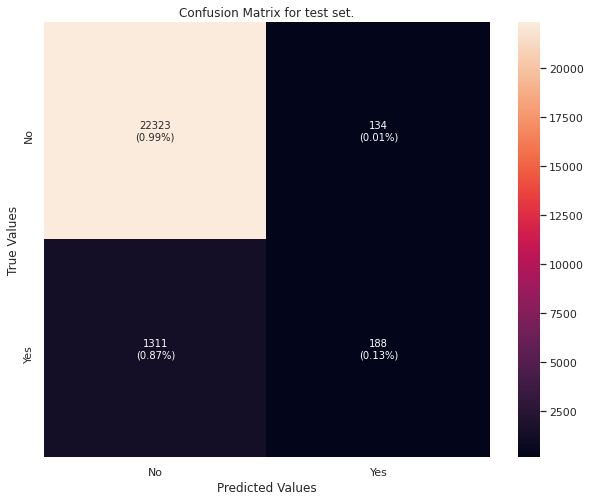

test [[22323   134]
 [ 1311   188]]
CPU times: user 6.87 s, sys: 212 ms, total: 7.08 s
Wall time: 6.84 s


In [74]:
%%time
gbc_init = GradientBoostingClassifier(init=AdaBoostClassifier(random_state=1),random_state=1)
gbc_init.fit(X_train, y_train)

#Using above defined function to get accuracy, recall and precision on train and test set
get_metrics_score(model=gbc_init,X_train=X_train, y_train=y_train,\
                  X_test=X_test, y_test=y_test ,flag=True, model_name="gbc_init")
ConfusionMatrix(y_test, gbc_init.predict(X_test), set1="test")

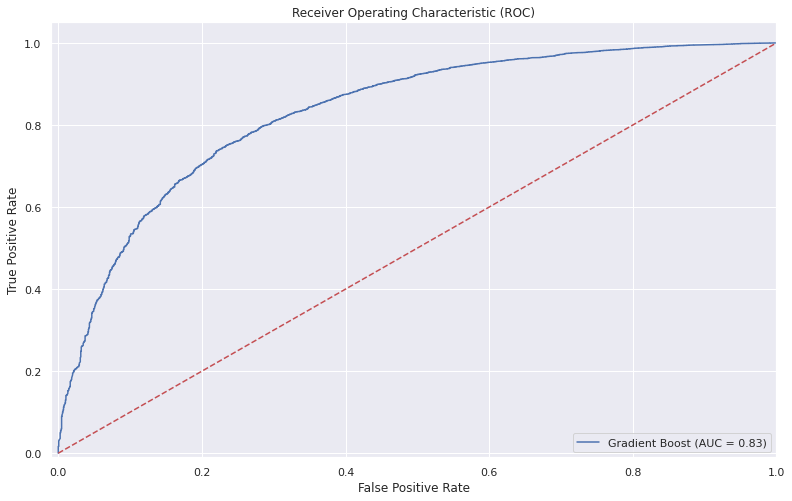

In [75]:
# AUC-ROC
logit_roc_auc = roc_auc_score(y_test, gbc_init.predict_proba(X_test)[:,1])
fpr, tpr, thresholds = roc_curve(y_test, gbc_init.predict_proba(X_test)[:,1])
plt.figure(figsize=(13,8))
plt.plot(fpr, tpr, label='Gradient Boost (AUC = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1.0])
plt.ylim([-0.01, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

**Results (Gradient Boosting)**: As expected the imbalanced data affects the performance of the model. The model predicts 99% correctly of non-defaulters (majority class -dominating) and only 13% correctly predicted for defaulters.

In [76]:
df3.default.value_counts(normalize=True)

1    0.93741
0    0.06259
Name: default, dtype: float64

* There are 94% of non-defaulters(1) and 6% of defaulters(0) in our data, so if our model predicts each sample as non-defaulter (like almost the case in above) the model will be 94% accurate. This is clearly shows that accuracy is not a good metric in this case. We will explore other options like Precision, Recall and F1. 

**What does a insurer want?**
* A insurer wants to minimize the loss - it can face 2 types of losses here: 
   * Whenever an insurer accepts a customer who will end up defaulting.
   * A insurer thinks that a customer will default yet they won't - opportunity loss.

**Which loss is greater ?**
* Customer defaulting.

**Since we don't want people to default on the premiums we should use Recall as a metric of model evaluation instead of accuracy.**

* Recall - It gives the ratio of True positives to Actual positives, so high Recall implies low false negatives, i.e. low chances of predicting a defaulter as non defaulter.

## Downsampling Majority Class (Non-defaulters)

- As explained earlier, the imbalanced data is a problem to our modelling process. In this section, we will downsample the majority class (non-dafulters) to the same size as the minority class.
- Downsampling is being done only on the training set but not on the test set. This is informed with the fact that the model actually learns from the training set.
- After downsampling, our training set contains 3499 examples for each class.
- **Since we are not donwsampling the test data the model precision scores will affected by this but we will keep focusing on the objective (maximizing the recall scores on the test data).**

In [77]:
# Filtering defaulters and non-defaulters
non_defaulters_ytrain = y_train.loc[y_train==1] # majority
defaulters_ytrain = y_train.loc[y_train==0] #minority

# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sample.html

# downsampling non defaulters randomly - extract indices
non_defaulters_ytrain_indices = non_defaulters_ytrain.sample(n=len(defaulters_ytrain), random_state=4).index
# extracting indices for defaulers
defaulters_ytrain_indices = defaulters_ytrain.index

# extract rows from imbalanced y_train using extracted indices 
y_train_nd_down = y_train.loc[non_defaulters_ytrain_indices]
y_train_d_down = y_train.loc[defaulters_ytrain_indices]

# extract rows from imbalanced X_train using extracted indices 
X_train_nd_down = X_train.loc[non_defaulters_ytrain_indices]
X_train_d_down = X_train.loc[defaulters_ytrain_indices]

# concatinate defaulters and non-defaulters data and shuffle
X_train_down = pd.concat([X_train_nd_down, X_train_d_down]).sample(frac=1, random_state=42)
y_train_down = pd.concat([y_train_nd_down, y_train_d_down]).sample(frac=1, random_state=42)


print('Distribution before downsampling: ',dict(y_train.value_counts()))
print('Distribution after downsampling: ',dict(y_train_down.value_counts())) # balanced

# Test data was not downsampled

Distribution before downsampling:  {1: 52398, 0: 3499}
Distribution after downsampling:  {0: 3499, 1: 3499}


<a id='gbm'></a>

## GradientBoosting Model after Downsampling

Accuracy on training set :  0.7819376964847099
Accuracy on test set :  0.7702037067957923
Recall on training set :  0.7650757359245499
Recall on test set :  0.733822548365577
Precision on training set :  0.7917775805974564
Precision on test set :  0.17724782468578795


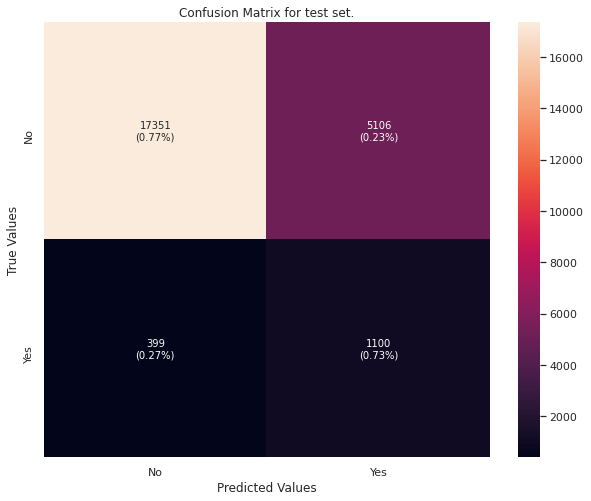

test [[17351  5106]
 [  399  1100]]
CPU times: user 1.74 s, sys: 193 ms, total: 1.93 s
Wall time: 1.71 s


In [78]:
%%time
gbc_init = GradientBoostingClassifier(init=AdaBoostClassifier(random_state=42),random_state=42)
gbc_init.fit(X_train_down, y_train_down)

#Using above defined function to get accuracy, recall and precision on train and test set
get_metrics_score(model=gbc_init,X_train=X_train_down, y_train=y_train_down,\
                  X_test=X_test, y_test=y_test ,flag=True, model_name="GradientBoosting_init_downsampled")
ConfusionMatrix(y_test, gbc_init.predict(X_test), set1="test")

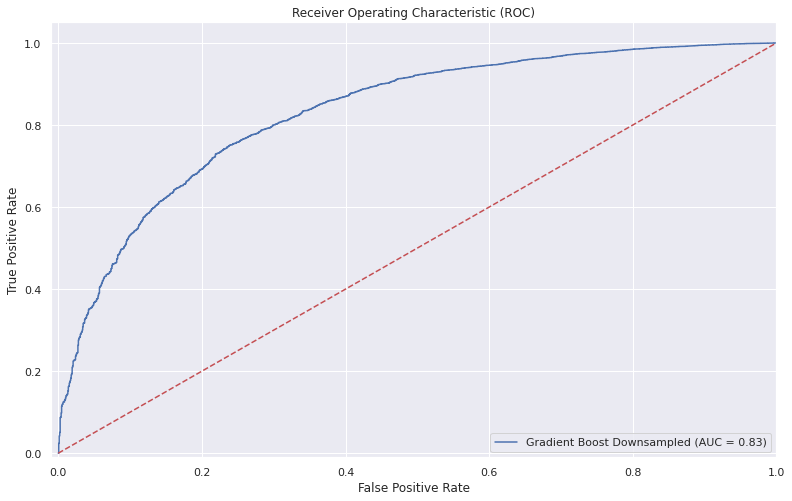

In [79]:
# AUC-ROC
logit_roc_auc = roc_auc_score(y_test, gbc_init.predict_proba(X_test)[:,1])
fpr, tpr, thresholds = roc_curve(y_test, gbc_init.predict_proba(X_test)[:,1])
plt.figure(figsize=(13,8))
plt.plot(fpr, tpr, label='Gradient Boost Downsampled (AUC = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1.0])
plt.ylim([-0.01, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

**Results (GradientBoosting after downsampling)** 
- After downsampling, the GradientBoost model is now able to predict correctly 73% of the defaulters up from initial 13% (This is the recall scores). The model's strength to predict non-defaulters however dropped to 77%. As said earlier, our biggest objective is to predict the defaulters more accurately.

## Upsampling Minority Class (Defaulters) USING SMOTE

- Another way to solve the problem of imbalanced data is to do upsampling. We will leverage upsampling technique called SMOTE(Synthetic Minority Oversampling Technique) which is based on synthetic generation of data for the minority class using the concept of k-Nearest Neighbors.
- After upsampling, the minority class was upsampled from 3499 to 52398.
- Once again, we are only upsampling the training data but not test data.

In [80]:
print("Before UpSampling, counts of label '1': {}".format(sum(y_train==1)))
print("Before UpSampling, counts of label '0': {} \n".format(sum(y_train==0)))

sm = SMOTE(sampling_strategy = 1 ,k_neighbors = 5, random_state=1)   #Synthetic Minority Over Sampling Technique
X_train_res, y_train_res = sm.fit_resample(X_train, y_train.ravel())

print("After UpSampling, counts of label '1': {}".format(sum(y_train_res==1)))
print("After UpSampling, counts of label '0': {} \n".format(sum(y_train_res==0)))

print('After UpSampling, the shape of train_X: {}'.format(X_train_res.shape))
print('After UpSampling, the shape of train_y: {} \n'.format(y_train_res.shape))

Before UpSampling, counts of label '1': 52398
Before UpSampling, counts of label '0': 3499 

After UpSampling, counts of label '1': 52398
After UpSampling, counts of label '0': 52398 

After UpSampling, the shape of train_X: (104796, 11)
After UpSampling, the shape of train_y: (104796,) 



## GradientBoosting after Upsampling

Accuracy on training set :  0.8018912935608229
Accuracy on test set :  0.777300050091835
Recall on training set :  0.8194205885720829
Recall on test set :  0.6731154102735156
Precision on training set :  0.7916658984050889
Precision on test set :  0.17236077895456098


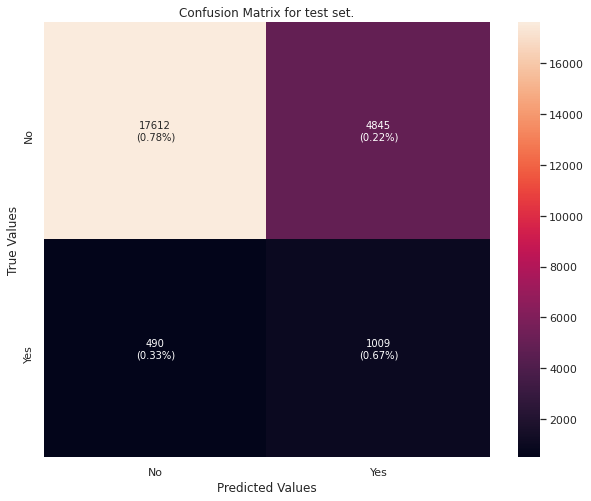

test [[17612  4845]
 [  490  1009]]
CPU times: user 15.8 s, sys: 205 ms, total: 16 s
Wall time: 15.8 s


In [81]:
%%time
gbc_init_up = GradientBoostingClassifier(init=AdaBoostClassifier(random_state=42),random_state=42)
gbc_init_up.fit(X_train_res, y_train_res)

#Using above defined function to get accuracy, recall and precision on train and test set
get_metrics_score(model=gbc_init_up,X_train=X_train_res, y_train=y_train_res,\
                  X_test=X_test, y_test=y_test ,flag=True, model_name="GradientBoost_init_upsampled")
ConfusionMatrix(y_test, gbc_init_up.predict(X_test), set1="test")

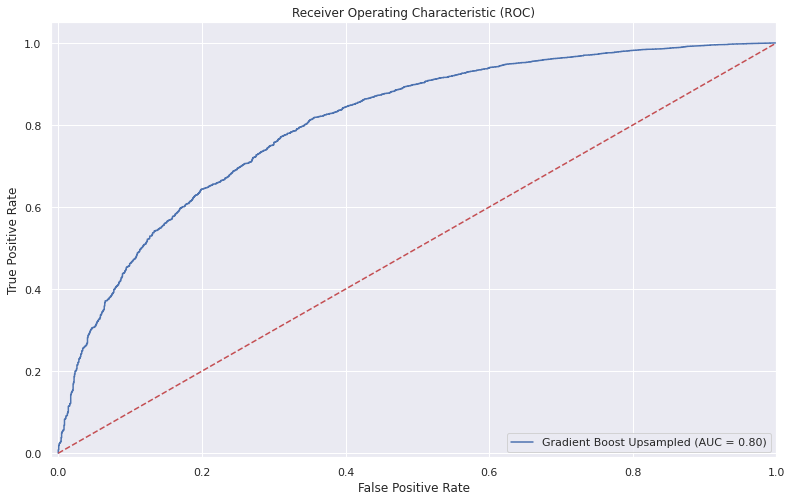

In [82]:
# AUC-ROC
logit_roc_auc = roc_auc_score(y_test, gbc_init_up.predict_proba(X_test)[:,1])
fpr, tpr, thresholds = roc_curve(y_test, gbc_init_up.predict_proba(X_test)[:,1])
plt.figure(figsize=(13,8))
plt.plot(fpr, tpr, label='Gradient Boost Upsampled (AUC = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1.0])
plt.ylim([-0.01, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [83]:
pd.DataFrame(model_results)

,model_name,train_acc,test_acc,train_recall,test_recall,train_precision,test_precision,train_f1,test_f1
0,gbc_init,0.940963,0.939681,0.134038,0.125417,0.634641,0.583851,0.221331,0.206480
1,GradientBoosting_init_downsampled,0.781938,0.770204,0.765076,0.733823,0.791778,0.177248,0.778198,0.285529
2,GradientBoost_init_upsampled,0.801891,0.777300,0.819421,0.673115,0.791666,0.172361,0.805304,0.274446


**Results (GradientBoosting on Upsampled Data):**

- Upsampling also solves the problem of biasedness toward majority class. As shown in the results above, the test recall on the upsampled data is 67% up from the 13% on the imbalanced data.
- Notice also that the model performs better on the the downsampled data compared to upsampled data, with test recall scores of 73% and 67% respectively.
- For this reason our training data will be the downsampled data from here on. This is also informed by the computational cost incurred..

In [84]:
X_train, y_train  = X_train_down, y_train_down

## DecisionTree Model with Default Parameters

Accuracy on training set :  0.9988568162332095
Accuracy on test set :  0.6727333444648522
Recall on training set :  0.9997142040583024
Recall on test set :  0.6611074049366245
Precision on training set :  0.9980028530670471
Precision on test set :  0.11906764387840922


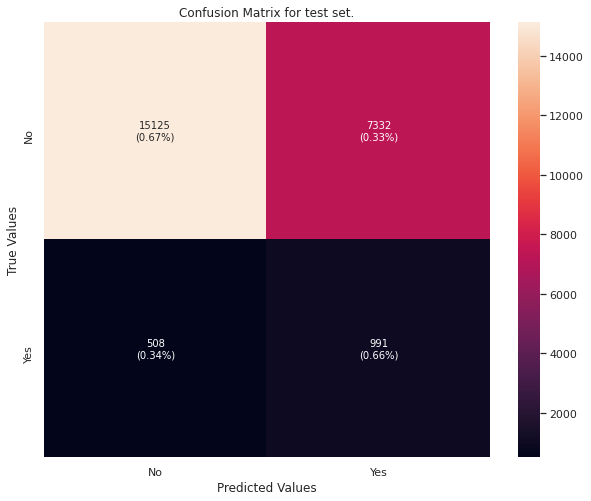

test [[15125  7332]
 [  508   991]]
CPU times: user 312 ms, sys: 173 ms, total: 485 ms
Wall time: 246 ms


In [85]:
%%time
dt_init = DecisionTreeClassifier(criterion = 'gini', random_state=42)
dt_init.fit(X_train, y_train)

#Using above defined function to get accuracy, recall and precision on train and test set
get_metrics_score(dt_init,X_train, y_train,\
                  X_test, y_test ,flag=True, model_name="DecisionTrees_init")
ConfusionMatrix(y_test, dt_init.predict(X_test), set1="test")

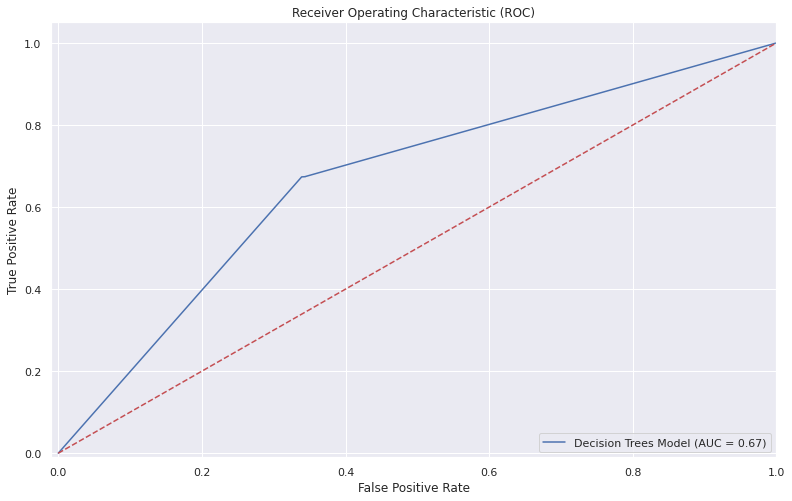

In [86]:
# AUC-ROC
logit_roc_auc = roc_auc_score(y_test, dt_init.predict_proba(X_test)[:,1])
fpr, tpr, thresholds = roc_curve(y_test, dt_init.predict_proba(X_test)[:,1])
plt.figure(figsize=(13,8))
plt.plot(fpr, tpr, label='Decision Trees Model (AUC = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1.0])
plt.ylim([-0.01, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

**Results (DecisionTrees Model):**
- DecisionTress Model highly overfits on the train data. For example, on the train data the model attains 99% recall score and only 66% on the test.

## DecisionTree Model with Max Depth Controlled

Accuracy on training set :  0.772649328379537
Accuracy on test set :  0.7362247453665053
Recall on training set :  0.7813661046013146
Recall on test set :  0.742494996664443
Precision on training set :  0.7679775280898876
Precision on test set :  0.15796196423502695


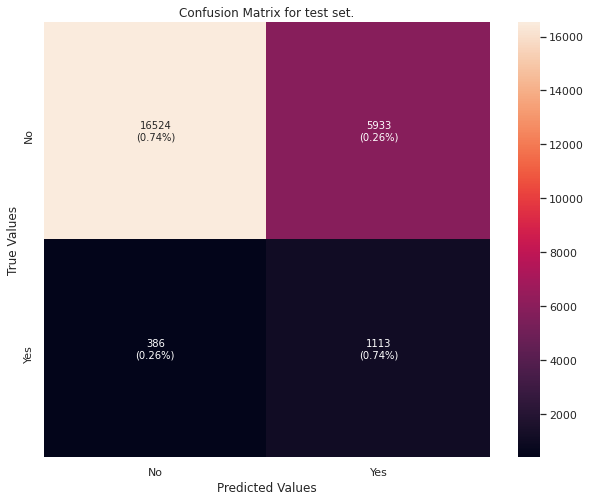

test [[16524  5933]
 [  386  1113]]
CPU times: user 243 ms, sys: 221 ms, total: 464 ms
Wall time: 232 ms


In [87]:
%%time
dt_init2 = DecisionTreeClassifier(criterion = 'gini', random_state=42, max_depth=6)
dt_init2.fit(X_train, y_train)

#Using above defined function to get accuracy, recall and precision on train and test set
get_metrics_score(dt_init2,X_train, y_train,\
                  X_test, y_test ,flag=True, model_name="DecisionTrees_MaxDepth6")
ConfusionMatrix(y_test, dt_init2.predict(X_test), set1="test")

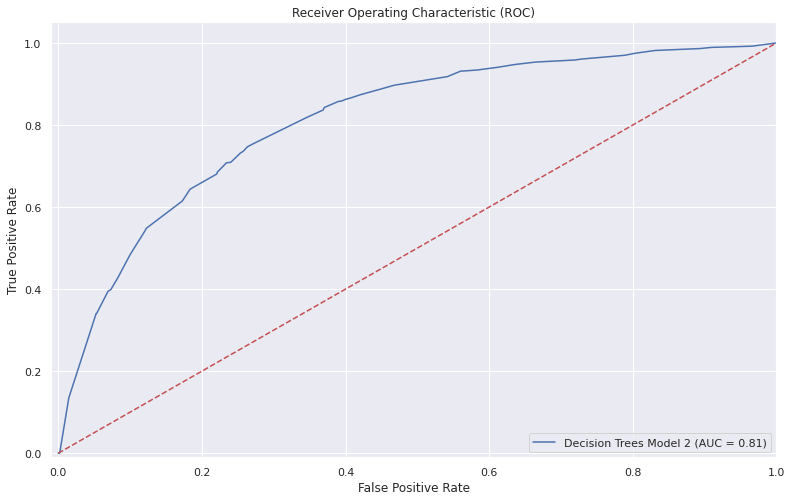

In [88]:
# AUC-ROC
logit_roc_auc = roc_auc_score(y_test, dt_init2.predict_proba(X_test)[:,1])
fpr, tpr, thresholds = roc_curve(y_test, dt_init2.predict_proba(X_test)[:,1])
plt.figure(figsize=(13,8))
plt.plot(fpr, tpr, label='Decision Trees Model 2 (AUC = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1.0])
plt.ylim([-0.01, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

**Results (DecisionTree model with Max Depth=6):**
- Clearly, controlling the max depth removes overfitting. Training and test recall scores now at 78% and 74%, respectively.
- Note: The precsion score on the training data is 76% and that of test data is 15%. This is not a case of overfitting. This discrepancy is based on the fact that we did not downsample the test data and it is not a problem.

In [89]:
# importance of features in the tree building ( The importance of a feature is computed as the 
#(normalized) total reduction of the criterion brought by that feature. It is also known as the Gini importance )

print (pd.DataFrame(dt_init2.feature_importances_, columns = ["Imp"], index = X_train.columns).sort_values(by = 'Imp', ascending = False))

                           Imp
late_pay              0.624037
perc_premium_by_cash  0.266956
risk_score            0.046474
no_of_premiums_paid   0.032028
age_groups            0.012321
income_groups         0.006878
dependants            0.004629
vehicles              0.003838
premium               0.002840
accomodation_0        0.000000
accomodation_1        0.000000


**Remark:** late_pay is the most important attribute according to DecisionTree model, followed by perc_premium_by_cash, and distant third is risk_score. This finding is true based on the fact that a customer who late in paying premium is highly likely to be the next defaulter.


## AdaBoost Classifier

Accuracy on training set :  0.7463929920989351
Accuracy on test set :  0.7874436466855903
Recall on training set :  0.6966868964464292
Recall on test set :  0.6991327551701134
Precision on training set :  0.773591303057916
Precision on test set :  0.18421515204781155


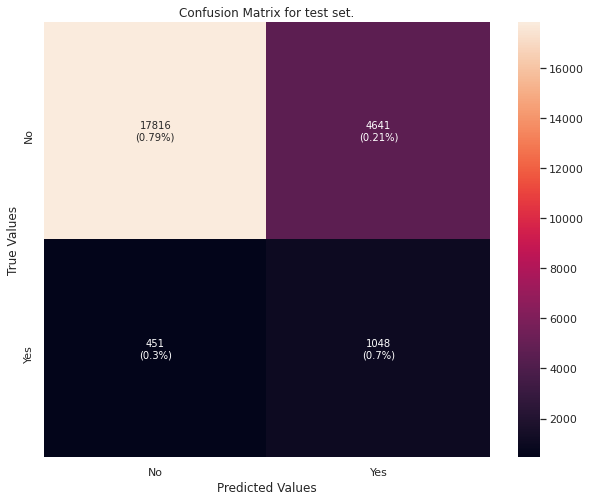

test [[17816  4641]
 [  451  1048]]
CPU times: user 2.64 s, sys: 204 ms, total: 2.85 s
Wall time: 2.62 s


In [90]:
%%time
ada_init = AdaBoostClassifier(random_state=42)
ada_init.fit(X_train, y_train)

#Using above defined function to get accuracy, recall and precision on train and test set
get_metrics_score(model=ada_init,X_train=X_train_res, y_train=y_train_res,\
                  X_test=X_test, y_test=y_test ,flag=True, model_name="AdaBoost_init")
ConfusionMatrix(y_test, ada_init.predict(X_test), set1="test")

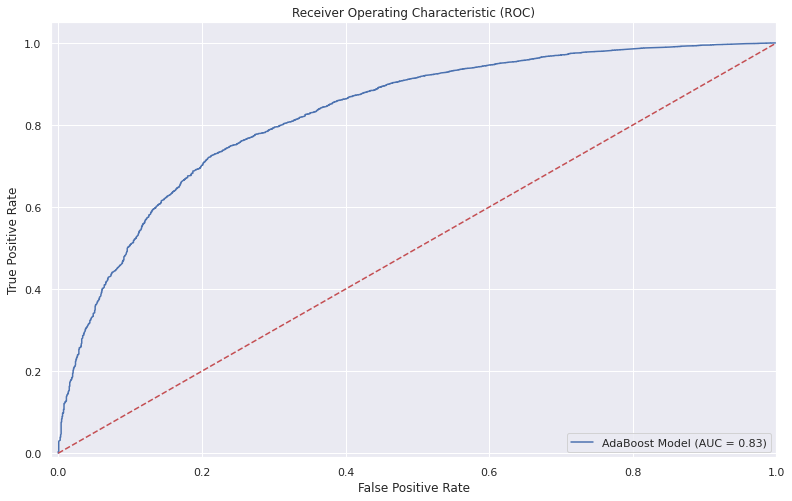

In [91]:
# AUC-ROC
logit_roc_auc = roc_auc_score(y_test, ada_init.predict_proba(X_test)[:,1])
fpr, tpr, thresholds = roc_curve(y_test, ada_init.predict_proba(X_test)[:,1])
plt.figure(figsize=(13,8))
plt.plot(fpr, tpr, label='AdaBoost Model (AUC = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1.0])
plt.ylim([-0.01, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

**Results (AdaBoost)** No overfitting and the rest of the results can be explained as before.

Accuracy on training set :  0.9988568162332095
Accuracy on test set :  0.7512940390716313
Recall on training set :  0.9994284081166047
Recall on test set :  0.7258172114743162
Precision on training set :  0.9982871824150727
Precision on test set :  0.16397889977392616


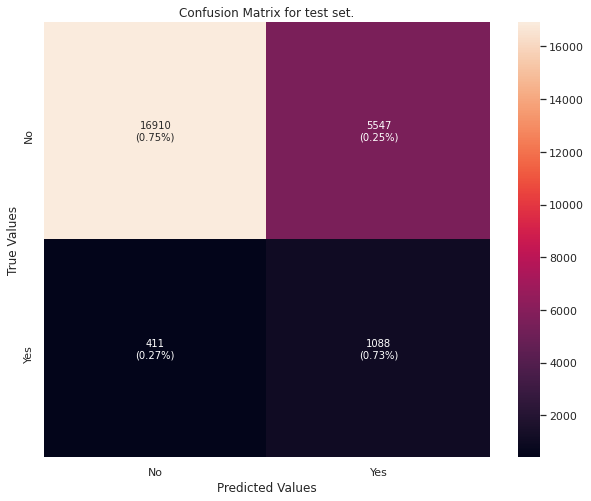

test [[16910  5547]
 [  411  1088]]
CPU times: user 2.17 s, sys: 188 ms, total: 2.36 s
Wall time: 2.14 s


In [92]:
%%time
rf_init = RandomForestClassifier(random_state=42)
rf_init.fit(X_train, y_train)

#Using above defined function to get accuracy, recall and precision on train and test set
get_metrics_score(rf_init,X_train, y_train,\
                  X_test, y_test ,flag=True, model_name="Random Forest_init")
ConfusionMatrix(y_test, rf_init.predict(X_test), set1="test")

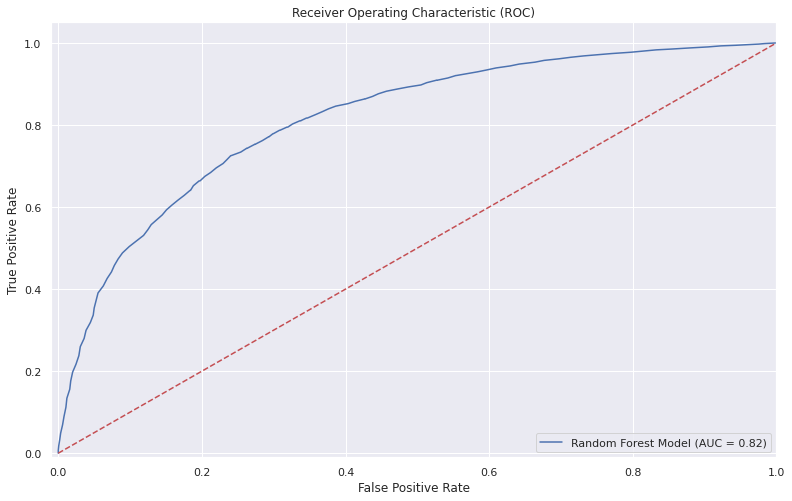

In [93]:
# AUC-ROC
logit_roc_auc = roc_auc_score(y_test, rf_init.predict_proba(X_test)[:,1])
fpr, tpr, thresholds = roc_curve(y_test, rf_init.predict_proba(X_test)[:,1])
plt.figure(figsize=(13,8))
plt.plot(fpr, tpr, label='Random Forest Model (AUC = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1.0])
plt.ylim([-0.01, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

**Results (AdaBoost)** RandomForest is well known for overfitting and it is the same case here. Later on we will explore methods of overcoming this. Selection of proper parameters is the center to solve the problem of overfitting.

Accuracy on training set :  0.9988568162332095
Accuracy on test set :  0.7512940390716313
Recall on training set :  0.9994284081166047
Recall on test set :  0.7258172114743162
Precision on training set :  0.9982871824150727
Precision on test set :  0.16397889977392616


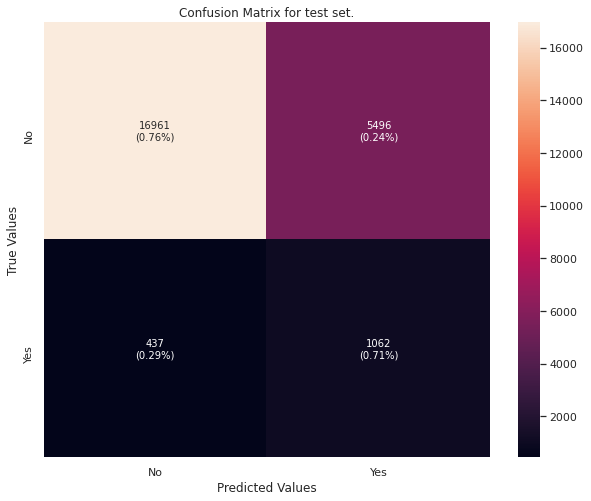

test [[16961  5496]
 [  437  1062]]
CPU times: user 3.96 s, sys: 198 ms, total: 4.15 s
Wall time: 1.71 s


In [94]:
%%time 
xg_init = XGBClassifier(use_label_encoder=False, random_state=42)
xg_init.fit(X_train, y_train, eval_metric="error")

#Using above defined function to get accuracy, recall and precision on train and test set
get_metrics_score(rf_init,X_train, y_train,\
                  X_test, y_test ,flag=True, model_name="XGBoost_init")
ConfusionMatrix(y_test, xg_init.predict(X_test), set1="test")

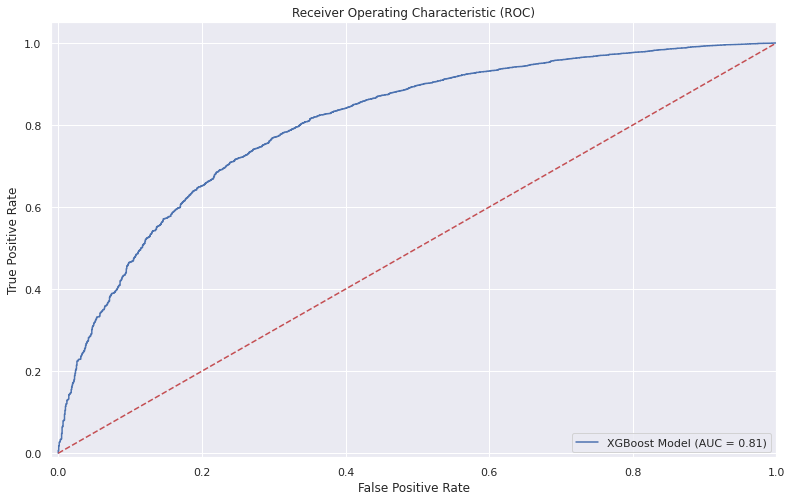

In [95]:
# AUC-ROC
logit_roc_auc = roc_auc_score(y_test, xg_init.predict_proba(X_test)[:,1])
fpr, tpr, thresholds = roc_curve(y_test, xg_init.predict_proba(X_test)[:,1])
plt.figure(figsize=(13,8))
plt.plot(fpr, tpr, label='XGBoost Model (AUC = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1.0])
plt.ylim([-0.01, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

Accuracy on training set :  0.7575021434695627
Accuracy on test set :  0.7792202371013525
Recall on training set :  0.7239211203200915
Recall on test set :  0.7064709806537692
Precision on training set :  0.7760416666666666
Precision on test set :  0.17924847664184157


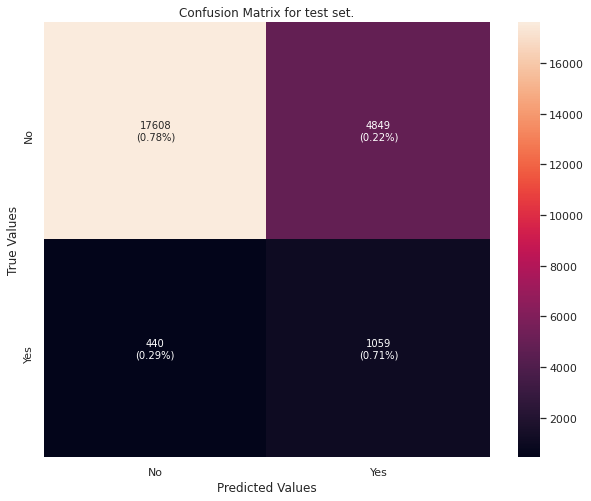

test [[17608  4849]
 [  440  1059]]
CPU times: user 673 ms, sys: 1.94 s, total: 2.61 s
Wall time: 422 ms


In [96]:
%%time
logistic_init = LogisticRegression(random_state=42, max_iter=600)
logistic_init.fit(X_train, y_train)

#Using above defined function to get accuracy, recall and precision on train and test set
get_metrics_score(logistic_init,X_train, y_train,\
                  X_test, y_test ,flag=True, model_name="LogisticRegression_init")
ConfusionMatrix(y_test, logistic_init.predict(X_test), set1="test")

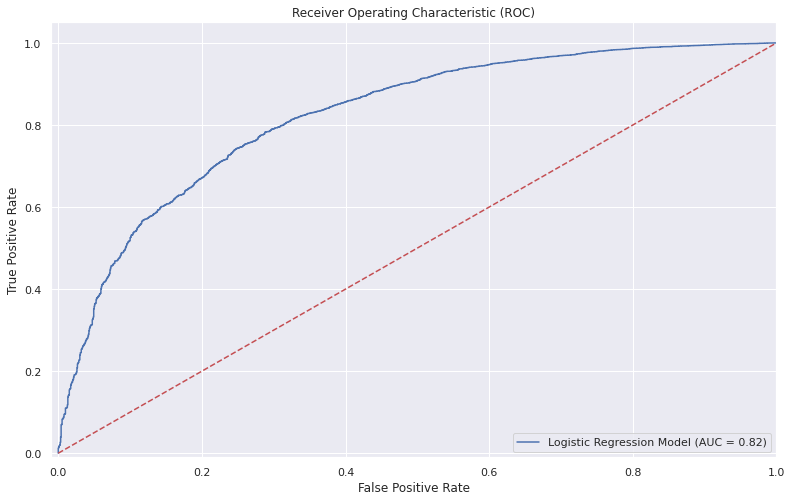

In [97]:
# AUC-ROC
logit_roc_auc = roc_auc_score(y_test, logistic_init.predict_proba(X_test)[:,1])
fpr, tpr, thresholds = roc_curve(y_test, logistic_init.predict_proba(X_test)[:,1])
plt.figure(figsize=(13,8))
plt.plot(fpr, tpr, label='Logistic Regression Model (AUC = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1.0])
plt.ylim([-0.01, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

**Results**
The following are the results of the models trained so far. The models that overfit have their hyperparameters tuned in the next sections.

In [98]:
pd.DataFrame(model_results)

,model_name,train_acc,test_acc,train_recall,test_recall,train_precision,test_precision,train_f1,test_f1
0,gbc_init,0.940963,0.939681,0.134038,0.125417,0.634641,0.583851,0.221331,0.206480
1,GradientBoosting_init_downsampled,0.781938,0.770204,0.765076,0.733823,0.791778,0.177248,0.778198,0.285529
2,GradientBoost_init_upsampled,0.801891,0.777300,0.819421,0.673115,0.791666,0.172361,0.805304,0.274446
3,DecisionTrees_init,0.998857,0.672733,0.999714,0.661107,0.998003,0.119068,0.998858,0.201792
4,DecisionTrees_MaxDepth6,0.772649,0.736225,0.781366,0.742495,0.767978,0.157962,0.774614,0.260503
5,AdaBoost_init,0.746393,0.787444,0.696687,0.699133,0.773591,0.184215,0.733128,0.291597
6,Random Forest_init,0.998857,0.751294,0.999428,0.725817,0.998287,0.163979,0.998857,0.267519
7,XGBoost_init,0.998857,0.751294,0.999428,0.725817,0.998287,0.163979,0.998857,0.267519
8,LogisticRegression_init,0.757502,0.779220,0.723921,0.706471,0.776042,0.179248,0.749076,0.285946


### Hyperparameter tuning

- Some models overfits as shown in the above table of results, for example, DecisionTree and RandomForest. We will now tune paramters of these models using GridSearchCV, RandomiSearchCV and PCA

## DecistionTree Classifier with Parameters Tuned

In [99]:
pipeline_dt = Pipeline(steps=[
                        ('pca', PCA()),
                        ("model",DecisionTreeClassifier(random_state=42))
])

# model = DecisionTreeClassifier(random_state=42)

param_grid = {
                'pca__n_components': [4,6,9],
                'model__criterion':["gini"],
                'model__max_depth': [6,9],
                'model__min_samples_split': [2, 4, 6, 8]
             } 

# print(pipeline_dt.get_params().keys())

# Type of scoring used to compare parameter combinations
acc_scorer = metrics.make_scorer(metrics.recall_score)

#Run GridSearchCV
grid_obj = GridSearchCV(pipeline_dt , param_grid = param_grid,scoring=acc_scorer, cv = 5, n_jobs=c_count) 
# Use validation set to search for best parameters
grid_obj = grid_obj.fit( X_train, y_train)


# Set the dt_tuned to the best combination of parameters
dt_tuned = grid_obj.best_estimator_

#Print best parameters
print(grid_obj.best_params_)

# Fit the best algorithm to the train data.
dt_tuned.fit(X_train, y_train)

{'model__criterion': 'gini', 'model__max_depth': 6, 'model__min_samples_split': 6, 'pca__n_components': 9}


Pipeline(steps=[('pca', PCA(n_components=9)),
                ('model',
                 DecisionTreeClassifier(max_depth=6, min_samples_split=6,
                                        random_state=42))])

Accuracy on training set :  0.7759359817090598
Accuracy on test set :  0.7582234095842377
Recall on training set :  0.7585024292655045
Recall on test set :  0.7204803202134756
Precision on training set :  0.7859046490968316
Precision on test set :  0.16736401673640167


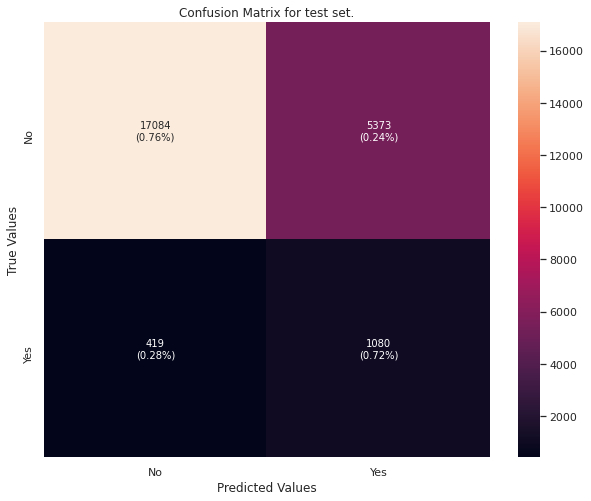

test [[17084  5373]
 [  419  1080]]


In [100]:
#Using above defined function to get accuracy, recall and precision on train and test set
get_metrics_score(dt_tuned,X_train, y_train,\
                  X_test, y_test ,flag=True, model_name="DecisionTree_tuned")
ConfusionMatrix(y_test, dt_tuned.predict(X_test), set1="test")

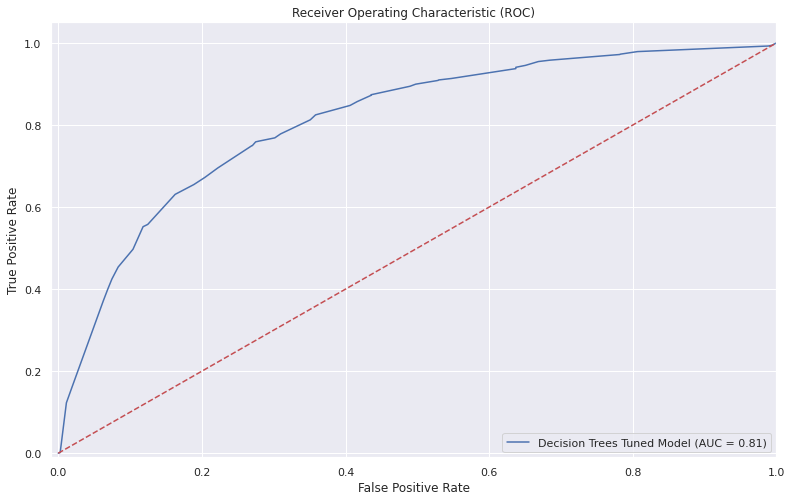

In [101]:
# AUC-ROC
logit_roc_auc = roc_auc_score(y_test, dt_tuned.predict_proba(X_test)[:,1])
fpr, tpr, thresholds = roc_curve(y_test, dt_tuned.predict_proba(X_test)[:,1])
plt.figure(figsize=(13,8))
plt.plot(fpr, tpr, label='Decision Trees Tuned Model (AUC = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1.0])
plt.ylim([-0.01, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

**Results (DecisionTree tuned)** Tuning of hyperparameters solves the problems of overfitting.

## Gradient Boosting Classifier with Parameters Tuned

In [102]:
# Define the pipeline with two processes: PCA and the classifier
pipeline_gbm = make_pipeline(
        (PCA()),
        (GradientBoostingClassifier(random_state=1))
)

# Grid of parameters to choose from
parameter_gbm = {
    "gradientboostingclassifier__n_estimators": np.arange(50,251,100),
    "gradientboostingclassifier__max_depth": np.arange(1,15,5),
    "gradientboostingclassifier__max_features": np.arange(0.4,1,0.2)
}

# Type of scoring used to compare parameter combinations
acc_scorer = metrics.make_scorer(metrics.recall_score)

# Run the grid search
grid_obj_gbm = GridSearchCV(pipeline_gbm, parameter_gbm, scoring=acc_scorer,cv=5, n_jobs=c_count)
grid_obj_gbm = grid_obj_gbm.fit(X_train, y_train)

# Set the clf to the best combination of parameters
gbm_tuned = grid_obj_gbm.best_estimator_

# Fit the best algorithm to the data.
gbm_tuned.fit(X_train, y_train)


Pipeline(steps=[('pca', PCA()),
                ('gradientboostingclassifier',
                 GradientBoostingClassifier(max_depth=1, max_features=0.4,
                                            n_estimators=50, random_state=1))])

Accuracy on training set :  0.7617890825950272
Accuracy on test set :  0.7910335615294707
Recall on training set :  0.7216347527865105
Recall on test set :  0.7031354236157439
Precision on training set :  0.7846488502175264
Precision on test set :  0.18771148708815671


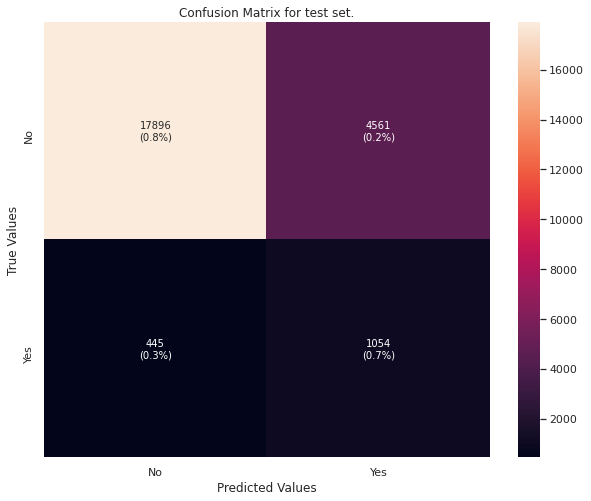

test [[17896  4561]
 [  445  1054]]


In [103]:
#Using above defined function to get accuracy, recall and precision on train and test set
get_metrics_score(gbm_tuned,X_train, y_train,\
                  X_test, y_test ,flag=True, model_name="GradientBoosting_tuned")
ConfusionMatrix(y_test, gbm_tuned.predict(X_test), set1="test")

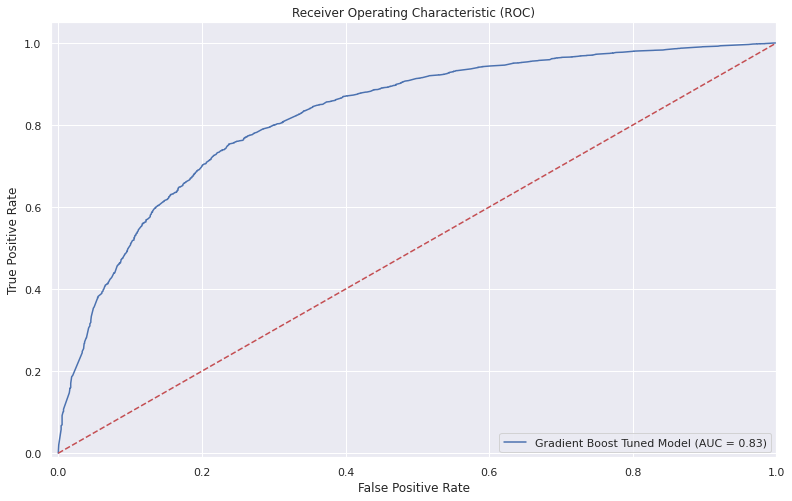

In [104]:
# AUC-ROC
logit_roc_auc = roc_auc_score(y_test, gbm_tuned.predict_proba(X_test)[:,1])
fpr, tpr, thresholds = roc_curve(y_test, gbm_tuned.predict_proba(X_test)[:,1])
plt.figure(figsize=(13,8))
plt.plot(fpr, tpr, label='Gradient Boost Tuned Model (AUC = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1.0])
plt.ylim([-0.01, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [105]:
pd.DataFrame(model_results)

,model_name,train_acc,test_acc,train_recall,test_recall,train_precision,test_precision,train_f1,test_f1
0,gbc_init,0.940963,0.939681,0.134038,0.125417,0.634641,0.583851,0.221331,0.206480
1,GradientBoosting_init_downsampled,0.781938,0.770204,0.765076,0.733823,0.791778,0.177248,0.778198,0.285529
2,GradientBoost_init_upsampled,0.801891,0.777300,0.819421,0.673115,0.791666,0.172361,0.805304,0.274446
3,DecisionTrees_init,0.998857,0.672733,0.999714,0.661107,0.998003,0.119068,0.998858,0.201792
4,DecisionTrees_MaxDepth6,0.772649,0.736225,0.781366,0.742495,0.767978,0.157962,0.774614,0.260503
5,AdaBoost_init,0.746393,0.787444,0.696687,0.699133,0.773591,0.184215,0.733128,0.291597
6,Random Forest_init,0.998857,0.751294,0.999428,0.725817,0.998287,0.163979,0.998857,0.267519
7,XGBoost_init,0.998857,0.751294,0.999428,0.725817,0.998287,0.163979,0.998857,0.267519
8,LogisticRegression_init,0.757502,0.779220,0.723921,0.706471,0.776042,0.179248,0.749076,0.285946
9,DecisionTree_tuned,0.775936,0.758223,0.758502,0.720480,0.785905,0.167364,0.771960,0.271630


## CHOSEN MODEL : GRADIENT BOOST MODEL WITH DEFAULT PARAMETERS

After analysis of 6 models and their variants, [Gradient Boost Model (GBM) with default parameters](#gbm) was ranked as the best model based on the test recall score. The model was fit with the following 10 attributes: perc_premium_by_cash, vehicles, dependants, risk_score, no_of_premiums_paid, premium, income_groups, age_groups, late_pay, and accomodation as a dummy variable.

GBM performed as follows:
- Accuracy on training set :  0.78
- Accuracy on test set :  0.77
- Recall on training set :  0.77
- Recall on test set :  0.73
- Precision on training set :  0.79
- Precision on test set :  0.18

## FEATURE IMPORTANCE

In [115]:
# Determining the most important features based on the best model
print (pd.DataFrame(gbc_init.feature_importances_, columns = ["Imp"], index = X_train.columns).sort_values(by = 'Imp', ascending = False))

                           Imp
late_pay              0.580014
perc_premium_by_cash  0.291202
risk_score            0.049573
no_of_premiums_paid   0.040741
age_groups            0.020209
income_groups         0.011523
dependants            0.002676
vehicles              0.002106
premium               0.001392
accomodation_0        0.000466
accomodation_1        0.000098


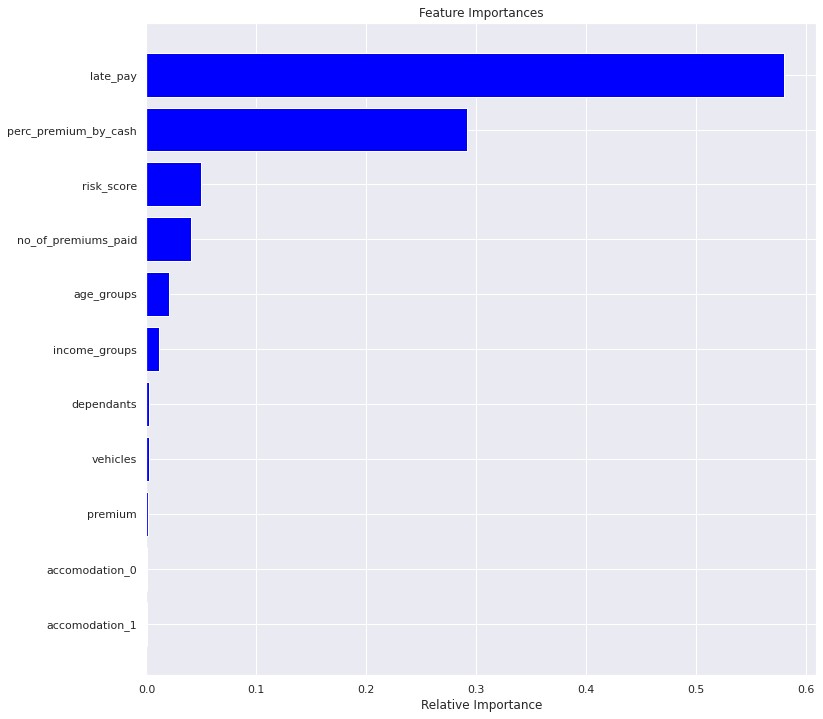

In [120]:
# Graphical presentation of the most imnportant features.
importances = gbc_init.feature_importances_
indices = np.argsort(importances)
feature_names = list(X.columns)

plt.figure(figsize=(12,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='blue', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

**[Feature importance]** 
- Out of the 10 attributes used in building the model, the following 6 columns are the most important attributes based on Gradient Boosting Model: late pay, perc_premium_by_cash, risk_score, no_of_premiums_paid, age_groups, and income_groups (from the most important).

- As expected, late_pay attribute is the most important column, that is, people who delay in paying the premiums are most likely to default.

- Note: late_pay is the sum of count3_6, count6_12, and df3.count12_more values.

## EXPLORATORY ANALYSIS OF BEST ATTRIBUTES/COLUMNS

In [136]:
# DataFrame with the top 6 features with target column
df_imp = pd.concat([X[["late_pay", "perc_premium_by_cash", "risk_score",\
                       "no_of_premiums_paid", "age_groups", "income_groups"]], y], axis=1)

In [137]:
df_imp.head()

,late_pay,perc_premium_by_cash,risk_score,no_of_premiums_paid,age_groups,income_groups,default
0,0,0.317,0.98810,8.0,1,1,1
1,0,0.000,0.99066,3.0,4,2,1
2,1,0.015,0.99170,14.0,2,2,1
3,0,0.000,0.99370,13.0,3,2,1
4,14,0.888,0.98800,15.0,2,2,0


In [152]:
# replace age_groups and income_group variables with initially used values
# it makes more sense that way

rank_replace2 = {
                "income_groups": {2: '100K-200K',
                                 3: '200K-300K',
                                 1: 'Under100K',
                                 4: '300K-400K',
                                 5: '400K-500K',
                                 7: 'Above600K',
                                 6: '500K-600K'},
                'age_groups': { 2: 'Age40-60',
                                 3: 'Age60-80',
                                 1: 'Age20-40',
                                 4: 'Above80'}
                }

df_imp = df_imp.replace(rank_replace2)

Age distribution:

Age20-40    0.240141
Above80     0.025622
Age40-60    0.483113
Age60-80    0.251124
Name: age_groups, dtype: float64


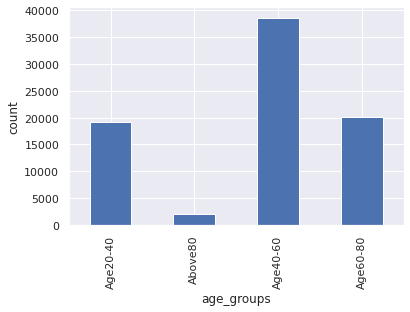

Age distribution:

Under100K    0.213179
100K-200K    0.398720
200K-300K    0.214983
300K-400K    0.104317
400K-500K    0.033549
Above600K    0.020538
500K-600K    0.014715
Name: income_groups, dtype: float64


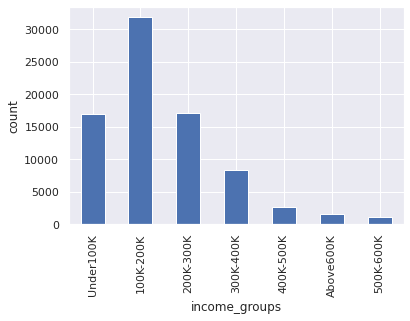

Age distribution:

1    0.93741
0    0.06259
Name: default, dtype: float64


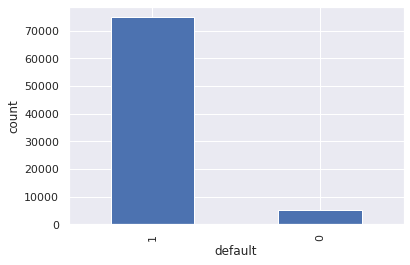

In [180]:
# counts of categorical variable
for cat in ["age_groups", "income_groups", "default"]:
    df_imp[cat].value_counts(normalize= True, sort=False)*100
    print('Age distribution:\n')
    print(df_imp[cat].value_counts(normalize= True, sort=False))
    df_imp[cat].value_counts(sort=False).plot(kind='bar')
    plt.xlabel(cat)
    plt.ylabel('count')
    plt.show()

Age distribution:

Age20-40    0.240141
Above80     0.025622
Age40-60    0.483113
Age60-80    0.251124
Name: age_groups, dtype: float64


Text(0, 0.5, 'count')

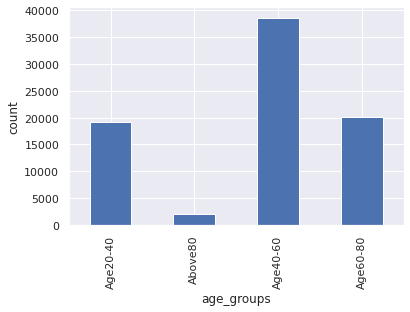

In [159]:
df_imp['age_groups'].value_counts(normalize= True, sort=False)*100

print('Age distribution:\n')
print(df_imp['age_groups'].value_counts(normalize= True, sort=False))
df_imp['age_groups'].value_counts(sort=False).plot(kind='bar')
plt.xlabel('age_groups')
plt.ylabel('count')

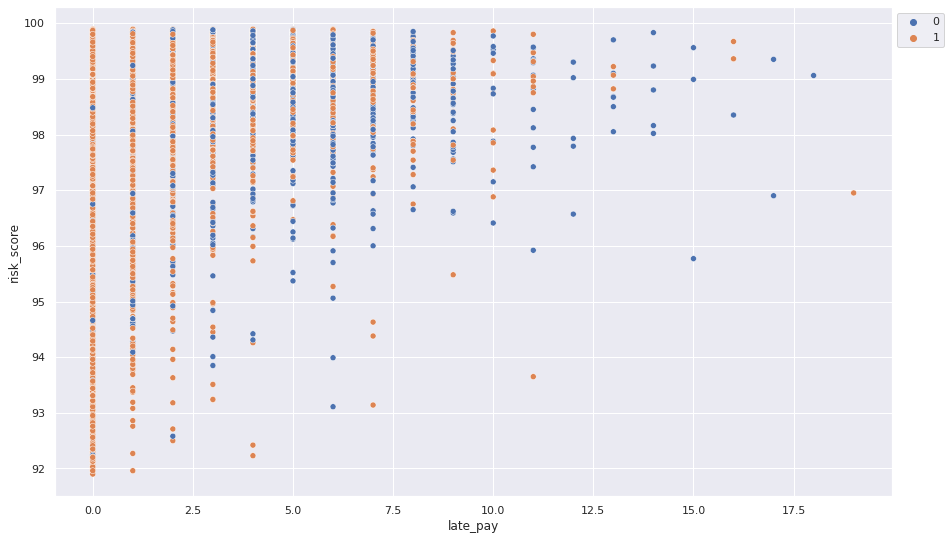

In [168]:
plt.figure(figsize=(15,9))
sns.scatterplot(x=df_imp.late_pay,y=df.risk_score,hue=df.default)
plt.legend(loc="upper left", bbox_to_anchor=(1,1));

In [179]:
# late_pay average by default category
df_imp[["late_pay", "default"]].groupby("default").mean().reset_index()

,default,late_pay
0,0,1.812925
1,1,0.291150


**Late Pay average:** - Defaulters has an average of 1.81 times of payment delay compaired to non-defaulters with 0.29

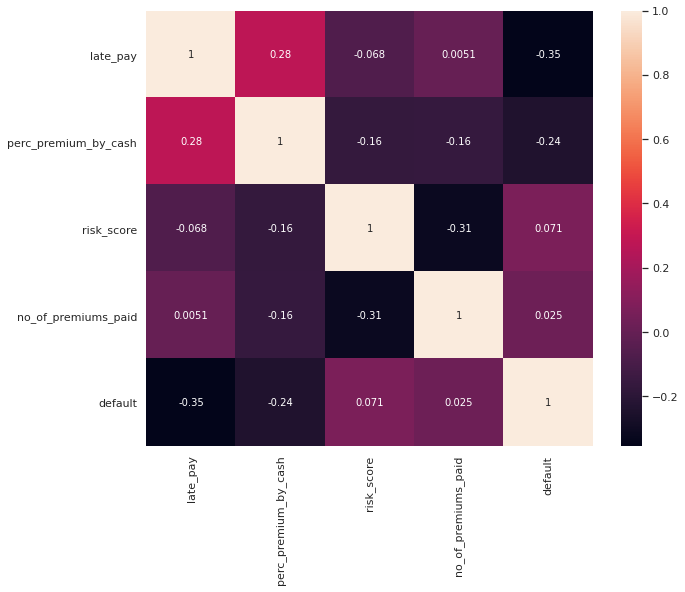

In [163]:
# Correlation between the 6 most important features
plt.figure(figsize=(10,8))
sns.heatmap(df_imp.corr(), annot=True);